In [1]:
'''

update history:

1、分区域逐月气候态及std
2、半岛降水主模态
3、分区降水回归
4、分区环流回归


=================================================
goals:

1、计算大论文需要的数据并存储至：/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data
2、画大论文第三章的图

'''
from mailbox import _PartialFile
import numpy as np
import xarray as xr
import os
import re
from cdo import Cdo
import shutil
import sys

sys.path.append("/home/ys17-23/chenhj/self_def/")
import plot as sepl
import cal as ca
import pandas as pd
from importlib import reload

import metpy.calc as mpcalc
import metpy.constants as constants
import geocat.comp
from windspharm.xarray import VectorWind
import skill_metrics as sm
from brokenaxes import brokenaxes

reload(sepl)

# sd.path.append("/home/ys17-23/chenhj/1201code/self_def.py")

cdo = Cdo()

# for plot
import proplot as pplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter
from cartopy.mpl.ticker import LatitudeFormatter
from cartopy.util import add_cyclic_point
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import t
from scipy import signal
from eofs.multivariate.standard import MultivariateEof
from eofs.standard import Eof
import statsmodels.api as sm

# 读取数据

In [2]:
fpreGPCP = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/GPCP_r144x72_197901-201412.nc"
)
preGPCP = fpreGPCP["precip"]
preGPCP_JJA = ca.p_time(preGPCP, 6, 8, True)
preGPCP_JJA = ca.detrend_dim(preGPCP_JJA, "time", deg=1, demean=False)

fhgtERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/hgt_mon_r144x72_195001-201412.nc")
hgtERA5 = fhgtERA5["z"].sel(time=fhgtERA5["time"].dt.year>=1979)

fuERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/uwind_mon_r144x72_195001-201412.nc"
)
uERA5 = fuERA5["u"].sel(time=fuERA5["time"].dt.year>=1979)

fvERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/vwind_mon_r144x72_195001-201412.nc"
)
vERA5 = fvERA5["v"].sel(time=fvERA5["time"].dt.year>=1979)

fspERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/sp_mon_r144x72_195001-201412.nc"
)
spERA5 = fspERA5["sp"].sel(time=fspERA5["time"].dt.year>=1979)

fqERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/q_mon_r144x72_195001-201412.nc")
qERA5 = fqERA5["q"].sel(time=fqERA5["time"].dt.year>=1979)

fwERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/omega_mon_r144x72_195001-201412.nc")
wERA5 = fwERA5["w"].sel(time=fwERA5["time"].dt.year>=1979)

fsstHad = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/HadISST_r144x72_1870-2020.nc")
sstHad = fsstHad["sst"].sel(time=(fsstHad["time"].dt.year>=1979) & (fsstHad["time"].dt.year<=2014))

hgtERA5_ver_JJA = ca.p_time(hgtERA5, 6, 8, True)
# hgtERA5_ver_JJA = hgtERA5_ver_JJA-hgtERA5_ver_JJA.mean(dim="lon", skipna=True)
hgtERA5_ver_JJA = ca.detrend_dim(hgtERA5_ver_JJA, "time", deg=1, demean=False)

uERA5_ver_MAM, uERA5_ver_JJA, uERA5_ver_SON, uERA5_ver_DJF = ca.mon_to_season(uERA5)
uERA5_ver_JJA_cli = uERA5_ver_JJA.copy()
uERA5_ver_MAM = ca.detrend_dim(uERA5_ver_MAM, "time", deg=1, demean=False)
uERA5_ver_JJA = ca.detrend_dim(uERA5_ver_JJA, "time", deg=1, demean=False)
uERA5_ver_SON = ca.detrend_dim(uERA5_ver_SON, "time", deg=1, demean=False)
uERA5_ver_DJF = ca.detrend_dim(uERA5_ver_DJF, "time", deg=1, demean=False)

vERA5_ver_MAM, vERA5_ver_JJA, vERA5_ver_SON, vERA5_ver_DJF = ca.mon_to_season(vERA5)
vERA5_ver_MAM = ca.detrend_dim(vERA5_ver_MAM, "time", deg=1, demean=False)
vERA5_ver_JJA = ca.detrend_dim(vERA5_ver_JJA, "time", deg=1, demean=False)
vERA5_ver_SON = ca.detrend_dim(vERA5_ver_SON, "time", deg=1, demean=False)
vERA5_ver_DJF = ca.detrend_dim(vERA5_ver_DJF, "time", deg=1, demean=False)

qERA5_ver_JJA = ca.p_time(qERA5, 6, 8, True)
qERA5_ver_JJA = ca.detrend_dim(qERA5_ver_JJA, "time", deg=1, demean=False)

spERA5_MAM, spERA5_JJA, spERA5_SON, spERA5_DJF = ca.mon_to_season(spERA5)
spERA5_MAM = ca.detrend_dim(spERA5_MAM, "time", deg=1, demean=False)
spERA5_JJA = ca.detrend_dim(spERA5_JJA, "time", deg=1, demean=False)
spERA5_SON = ca.detrend_dim(spERA5_SON, "time", deg=1, demean=False)
spERA5_DJF = ca.detrend_dim(spERA5_DJF, "time", deg=1, demean=False)

wERA5_MAM, wERA5_JJA, wERA5_SON, wERA5_DJF = ca.mon_to_season(wERA5)
wERA5_MAM = ca.detrend_dim(wERA5_MAM, "time", deg=1, demean=False)
wERA5_JJA = ca.detrend_dim(wERA5_JJA, "time", deg=1, demean=False)
wERA5_SON = ca.detrend_dim(wERA5_SON, "time", deg=1, demean=False)
wERA5_DJF = ca.detrend_dim(wERA5_DJF, "time", deg=1, demean=False)
sstHad_MAM, sstHad_JJA, sstHad_SON, sstHad_DJF = ca.mon_to_season(sstHad)
sstHad_MAM = ca.detrend_dim(sstHad_MAM, "time", deg=1, demean=False)
sstHad_JJA = ca.detrend_dim(sstHad_JJA, "time", deg=1, demean=False)
sstHad_SON = ca.detrend_dim(sstHad_SON, "time", deg=1, demean=False)
sstHad_DJF = ca.detrend_dim(sstHad_DJF, "time", deg=1, demean=False)
ftERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/temp_mon_r144x72_195001-201412.nc")
tERA5 = ftERA5["t"].sel(time=ftERA5["time"].dt.year>=1979)
tERA5_ver_JJA = ca.p_time(tERA5, 6, 8, True)
tERA5_ver_JJA = ca.detrend_dim(tERA5_ver_JJA, "time", deg=1, demean=False)
divERA5_ver_JJA = ca.cal_divergence(uERA5_ver_JJA.sel(level=[200.0, 850.0]), vERA5_ver_JJA.sel(level=[200.0, 850.0]))
divERA5_ver_JJA = ca.detrend_dim(divERA5_ver_JJA, "time", deg=1, demean=False)

#   calculate the waver vapor vertical intergration
ptop = 1
g = 9.8
ERA5level = qERA5_ver_JJA.coords["level"].where(qERA5_ver_JJA.coords["level"] >= ptop) * 100.0
ERA5level.attrs["units"] = "Pa"
ERA5dp = geocat.comp.dpres_plevel(ERA5level, spERA5_JJA, ptop*100)
ERA5dpg = ERA5dp / g
ERA5dpg.attrs["units"] = "kg/m2"
# calculate the water vapor transport
integration_top = 200
uq_sl_ERA5_JJA = uERA5_ver_JJA.loc[:, integration_top:, :, :] * qERA5_ver_JJA.loc[:, integration_top:, :, :].data * 1000.0
vq_sl_ERA5_JJA = vERA5_ver_JJA.loc[:, integration_top:, :, :] * qERA5_ver_JJA.loc[:, integration_top:, :, :].data * 1000.0
uq_sl_ERA5_JJA.attrs["units"] = "[m/s][g/kg]"
vq_sl_ERA5_JJA.attrs["units"] = "[m/s][g/kg]"
# calculate the whole levels water vapor transport
uqERA5_ver_JJA = (uq_sl_ERA5_JJA * ERA5dpg[:, list(ERA5level).index(integration_top*100):, :, :].data).sum(dim="level") / 1e05
vqERA5_ver_JJA = (vq_sl_ERA5_JJA * ERA5dpg[:, list(ERA5level).index(integration_top*100):, :, :].data).sum(dim="level") / 1e05
uqERA5_ver_JJA.attrs["units"] = "100kg m-1 s-1"
vqERA5_ver_JJA.attrs["units"] = "100kg m-1 s-1"
uqERA5_ver_JJA = ca.detrend_dim(uqERA5_ver_JJA, "time", deg=1, demean=False)
vqERA5_ver_JJA = ca.detrend_dim(vqERA5_ver_JJA, "time", deg=1, demean=False)
# calculate the water vapor transportation divergence
uqvqdivERA5_ver_JJA = ca.cal_divergence(uqERA5_ver_JJA, vqERA5_ver_JJA)
uqvqdivERA5_ver_JJA = ca.detrend_dim(uqvqdivERA5_ver_JJA, "time", deg=1, demean=False)

# 计算分区域降水

In [3]:
lat = preGPCP_JJA.coords["lat"]
lon = preGPCP_JJA.coords["lon"]
# 全印度
India_N = 35.0
India_S = 5.0
India_W = 70.0
India_E = 85.0
lat_India_range = lat[(lat >= India_S) & (lat <= India_N)]
lon_India_range = lon[(lon >= India_W) & (lon <= India_E)]

preGPCP_India_JJA = ca.cal_area_weighted_mean(preGPCP_JJA.sel(lat=lat_India_range, lon=lon_India_range))
preGPCP_India_JJA = ca.detrend_dim(preGPCP_India_JJA, "time", deg=1, demean=True)
# standardize
preGPCP_India_JJA_nor = ca.standardize(preGPCP_India_JJA)

# 印度半岛北部
nIndia_N = 35.0
nIndia_S = 20.0
nIndia_W = 70.0
nIndia_E = 85.0
lat_nIndia_range = lat[(lat >= nIndia_S) & (lat <= nIndia_N)]
lon_nIndia_range = lon[(lon >= nIndia_W) & (lon <= nIndia_E)]

preGPCP_nIndia_JJA = ca.cal_lat_weighted_mean(preGPCP_JJA.sel(lat=lat_nIndia_range, lon=lon_nIndia_range)).mean(dim="lon", skipna=True)
preGPCP_nIndia_JJA = ca.detrend_dim(preGPCP_nIndia_JJA, "time", deg=1, demean=True)
# standardize
preGPCP_nIndia_JJA_nor = ca.standardize(preGPCP_nIndia_JJA)

# 印度半岛南部
sIndia_N = 20.0
sIndia_S = 5.0
sIndia_W = 70.0
sIndia_E = 85.0
lat_sIndia_range = lat[(lat >= sIndia_S) & (lat <= sIndia_N)]
lon_sIndia_range = lon[(lon >= sIndia_W) & (lon <= sIndia_E)]

preGPCP_sIndia_JJA = ca.cal_lat_weighted_mean(preGPCP_JJA.sel(lat=lat_sIndia_range, lon=lon_sIndia_range)).mean(dim="lon", skipna=True)
preGPCP_sIndia_JJA = ca.detrend_dim(preGPCP_sIndia_JJA, "time", deg=1, demean=True)
# standardize
preGPCP_sIndia_JJA_nor = ca.standardize(preGPCP_sIndia_JJA)


# 华北地区
NC_N = 40.0
NC_S = 32.5
NC_W = 105.0
NC_E = 120.0
lat_NC_range = lat[(lat >= NC_S) & (lat <= NC_N)]
lon_NC_range = lon[(lon >= NC_W) & (lon <= NC_E)]
preGPCP_NC_JJA = ca.cal_area_weighted_mean(preGPCP_JJA.sel(lat=lat_NC_range, lon=lon_NC_range))
preGPCP_NC_JJA = ca.detrend_dim(preGPCP_NC_JJA, "time", deg=1, demean=True)
# standardize
preGPCP_NC_JJA_nor = ca.standardize(preGPCP_NC_JJA)

# 长江中下游地区
YZR_N = 32.5
YZR_S = 27.5
YZR_W = 105.0
YZR_E = 120.0
lat_YZR_range = lat[(lat >= YZR_S) & (lat <= YZR_N)]
lon_YZR_range = lon[(lon >= YZR_W) & (lon <= YZR_E)]
preGPCP_YZR_JJA = ca.cal_area_weighted_mean(preGPCP_JJA.sel(lat=lat_YZR_range, lon=lon_YZR_range))
preGPCP_YZR_JJA = ca.detrend_dim(preGPCP_YZR_JJA, "time", deg=1, demean=True)
# standardize
preGPCP_YZR_JJA_nor = ca.standardize(preGPCP_YZR_JJA)

# 日本南部
SJ_N = 35
SJ_S = 30
SJ_W = 130.0
SJ_E = 137.5
lat_SJ_range = lat[(lat >= SJ_S) & (lat <= SJ_N)]
lon_SJ_range = lon[(lon >= SJ_W) & (lon <= SJ_E)]
preGPCP_SJ_JJA = ca.cal_area_weighted_mean(preGPCP_JJA.sel(lat=lat_SJ_range, lon=lon_SJ_range))
preGPCP_SJ_JJA = ca.detrend_dim(preGPCP_SJ_JJA, "time", deg=1, demean=True)
# standardize
preGPCP_SJ_JJA_nor = ca.standardize(preGPCP_SJ_JJA)

# 计算分月分区域降水

In [4]:
preGPCP_mon = ca.p_month(preGPCP, 1, 12)
preGPCP_mon_detrend = ca.detrend_dim(preGPCP_mon.copy())

# 全印度
preGPCP_India_mon_cli = ca.cal_area_weighted_mean(preGPCP_mon.sel(lat=lat_India_range, lon=lon_India_range))
preGPCP_India_mon = ca.detrend_dim(preGPCP_India_mon_cli)
preGPCP_India_mon_nor = ca.standardize(preGPCP_India_mon)

# 华北地区
preGPCP_NC_mon_cli = ca.cal_area_weighted_mean(preGPCP_mon.sel(lat=lat_NC_range, lon=lon_NC_range))
preGPCP_NC_mon = ca.detrend_dim(preGPCP_NC_mon_cli)
preGPCP_NC_mon_nor = ca.standardize(preGPCP_NC_mon)

# 长江中下游地区
preGPCP_YZR_mon_cli = ca.cal_area_weighted_mean(preGPCP_mon.sel(lat=lat_YZR_range, lon=lon_YZR_range))
preGPCP_YZR_mon = ca.detrend_dim(preGPCP_YZR_mon_cli)
preGPCP_YZR_mon_nor = ca.standardize(preGPCP_YZR_mon)

# 日本南部地区
preGPCP_SJ_mon_cli = ca.cal_area_weighted_mean(preGPCP_mon.sel(lat=lat_SJ_range, lon=lon_SJ_range))
preGPCP_SJ_mon = ca.detrend_dim(preGPCP_SJ_mon_cli)
preGPCP_SJ_mon_nor = ca.standardize(preGPCP_SJ_mon)

# 分月 分区域求相关

In [5]:
_,_,IndR_NC_mon_rvalue,_,_ = ca.dim_linregress(preGPCP_India_mon_nor, preGPCP_NC_mon_nor)
_,_,IndR_YZR_mon_rvalue,_,_ = ca.dim_linregress(preGPCP_India_mon_nor, preGPCP_YZR_mon_nor)
_,_,IndR_SJ_mon_rvalue,_,_ = ca.dim_linregress(preGPCP_India_mon_nor, preGPCP_SJ_mon_nor)

# 计算半岛降水主模态

In [6]:
preGPCP_India_EOFs, preGPCP_India_PCs, preGPCP_India_percon = ca.eof_analyse(ca.standardize(ca.detrend_dim(preGPCP_JJA.sel(lat=lat_India_range, lon=lon_India_range))).data, lat_India_range.data, num=2, montecarlo=True)

['True', 'True', 'True', 'True', 'True', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'False']


In [7]:
preGPCP_India_EOFs = xr.DataArray(
  data=preGPCP_India_EOFs, 
  dims=["modes", "lat", "lon"], 
  coords=dict(
    modes=np.arange(1,3),
    lat=lat_India_range.data,
    lon=lon_India_range.data
  )
)
preGPCP_India_PCs = xr.DataArray(
  data=preGPCP_India_PCs, 
  dims=["time", "modes"], 
  coords=dict(
    time=preGPCP_JJA.time.data,
    modes=np.arange(1,3),
  )
)

In [8]:
(EOF_GPCP_pre_slope,_,EOF_GPCP_pre_rvalue,EOF_GPCP_pre_pvalue,_) = ca.dim_linregress(preGPCP_India_PCs, preGPCP_JJA)

# 计算分区降水回归

In [9]:
(
    IndR_GPCP_pre_slope,
    IndR_GPCP_pre_intercept,
    IndR_GPCP_pre_rvalue,
    IndR_GPCP_pre_pvalue,
    IndR_GPCP_pre_hypothesis,
) = ca.dim_linregress(preGPCP_India_JJA_nor, preGPCP_JJA)

(
    NC_GPCP_pre_slope,
    NC_GPCP_pre_intercept,
    NC_GPCP_pre_rvalue,
    NC_GPCP_pre_pvalue,
    NC_GPCP_pre_hypothesis,
) = ca.dim_linregress(preGPCP_NC_JJA_nor, preGPCP_JJA)

(
    YZR_GPCP_pre_slope,
    YZR_GPCP_pre_intercept,
    YZR_GPCP_pre_rvalue,
    YZR_GPCP_pre_pvalue,
    YZR_GPCP_pre_hypothesis,
) = ca.dim_linregress(preGPCP_YZR_JJA_nor, preGPCP_JJA)

(
    SJ_GPCP_pre_slope,
    SJ_GPCP_pre_intercept,
    SJ_GPCP_pre_rvalue,
    SJ_GPCP_pre_pvalue,
    SJ_GPCP_pre_hypothesis,
) = ca.dim_linregress(preGPCP_SJ_JJA_nor, preGPCP_JJA)

In [10]:
(
    nIndR_GPCP_pre_slope,
    nIndR_GPCP_pre_intercept,
    nIndR_GPCP_pre_rvalue,
    nIndR_GPCP_pre_pvalue,
    nIndR_GPCP_pre_hypothesis,
) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, preGPCP_JJA)

(
    sIndR_GPCP_pre_slope,
    sIndR_GPCP_pre_intercept,
    sIndR_GPCP_pre_rvalue,
    sIndR_GPCP_pre_pvalue,
    sIndR_GPCP_pre_hypothesis,
) = ca.dim_linregress(preGPCP_sIndia_JJA_nor, preGPCP_JJA)

# 计算分区环流回归

In [ ]:
# preGPCP_nIndia_JJA_nor.coords["time"] = hgtERA5_ver_JJA.time
# (
#     nIndR_ERA5_hgt_slope,
#     nIndR_ERA5_hgt_intercept,
#     nIndR_ERA5_hgt_rvalue,
#     nIndR_ERA5_hgt_pvalue,
#     nIndR_ERA5_hgt_hypothesis,
# ) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, hgtERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

# preGPCP_nIndia_JJA_nor.coords["time"] = uERA5_ver_JJA.time
# (
#     nIndR_ERA5_uJJA_slope,
#     nIndR_ERA5_uJJA_intercept,
#     nIndR_ERA5_uJJA_rvalue,
#     nIndR_ERA5_uJJA_pvalue,
#     nIndR_ERA5_uJJA_hypothesis,
# ) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, uERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

# (
#     nIndR_ERA5_vJJA_slope,
#     nIndR_ERA5_vJJA_intercept,
#     nIndR_ERA5_vJJA_rvalue,
#     nIndR_ERA5_vJJA_pvalue,
#     nIndR_ERA5_vJJA_hypothesis,
# ) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, vERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

# preGPCP_sIndia_JJA_nor.coords["time"] = hgtERA5_ver_JJA.time
# (
#     sIndR_ERA5_hgt_slope,
#     sIndR_ERA5_hgt_intercept,
#     sIndR_ERA5_hgt_rvalue,
#     sIndR_ERA5_hgt_pvalue,
#     sIndR_ERA5_hgt_hypothesis,
# ) = ca.dim_linregress(preGPCP_sIndia_JJA_nor, hgtERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

# preGPCP_sIndia_JJA_nor.coords["time"] = uERA5_ver_JJA.time
# (
#     sIndR_ERA5_uJJA_slope,
#     sIndR_ERA5_uJJA_intercept,
#     sIndR_ERA5_uJJA_rvalue,
#     sIndR_ERA5_uJJA_pvalue,
#     sIndR_ERA5_uJJA_hypothesis,
# ) = ca.dim_linregress(preGPCP_sIndia_JJA_nor, uERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

# (
#     sIndR_ERA5_vJJA_slope,
#     sIndR_ERA5_vJJA_intercept,
#     sIndR_ERA5_vJJA_rvalue,
#     sIndR_ERA5_vJJA_pvalue,
#     sIndR_ERA5_vJJA_hypothesis,
# ) = ca.dim_linregress(preGPCP_sIndia_JJA_nor, vERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

# (
#     IndR_ERA5_hgt_slope,
#     IndR_ERA5_hgt_intercept,
#     IndR_ERA5_hgt_rvalue,
#     IndR_ERA5_hgt_pvalue,
#     IndR_ERA5_hgt_hypothesis,
# ) = ca.dim_linregress(preGPCP_India_JJA_nor, hgtERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))
# preGPCP_India_JJA_nor.coords["time"] = uERA5_ver_JJA.time
# (
#     IndR_ERA5_uJJA_slope,
#     IndR_ERA5_uJJA_intercept,
#     IndR_ERA5_uJJA_rvalue,
#     IndR_ERA5_uJJA_pvalue,
#     IndR_ERA5_uJJA_hypothesis,
# ) = ca.dim_linregress(preGPCP_India_JJA_nor, uERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

# (
#     IndR_ERA5_vJJA_slope,
#     IndR_ERA5_vJJA_intercept,
#     IndR_ERA5_vJJA_rvalue,
#     IndR_ERA5_vJJA_pvalue,
#     IndR_ERA5_vJJA_hypothesis,
# ) = ca.dim_linregress(preGPCP_India_JJA_nor, vERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

In [ ]:


# nIndR_ERA5_uJJA_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["level", "lat", "lon"], nIndR_ERA5_uJJA_slope.data),
#         intercept=(["level", "lat", "lon"], nIndR_ERA5_uJJA_intercept.data),
#         rvalue=(["level", "lat", "lon"], nIndR_ERA5_uJJA_rvalue.data),
#         pvalue=(["level", "lat", "lon"], nIndR_ERA5_uJJA_pvalue.data),
#         hypothesis=(["level", "lat", "lon"], nIndR_ERA5_uJJA_hypothesis.data),
#     ),
#     coords=dict(
#         level=np.array([200.0, 850.0, 1000.0]),
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
# )
# sIndR_ERA5_uJJA_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["level", "lat", "lon"], sIndR_ERA5_uJJA_slope.data),
#         intercept=(["level", "lat", "lon"], sIndR_ERA5_uJJA_intercept.data),
#         rvalue=(["level", "lat", "lon"], sIndR_ERA5_uJJA_rvalue.data),
#         pvalue=(["level", "lat", "lon"], sIndR_ERA5_uJJA_pvalue.data),
#         hypothesis=(["level", "lat", "lon"], sIndR_ERA5_uJJA_hypothesis.data),
#     ),
#     coords=dict(
#         level=np.array([200.0, 850.0, 1000.0]),
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
# )
# IndR_ERA5_uJJA_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["level", "lat", "lon"], IndR_ERA5_uJJA_slope.data),
#         intercept=(["level", "lat", "lon"], IndR_ERA5_uJJA_intercept.data),
#         rvalue=(["level", "lat", "lon"], IndR_ERA5_uJJA_rvalue.data),
#         pvalue=(["level", "lat", "lon"], IndR_ERA5_uJJA_pvalue.data),
#         hypothesis=(["level", "lat", "lon"], IndR_ERA5_uJJA_hypothesis.data),
#     ),
#     coords=dict(
#         level=np.array([200.0, 850.0, 1000.0]),
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
# )

# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_uJJA_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_uJJA_regress.nc")
# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_uJJA_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_uJJA_regress.nc")
# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/IndR_ERA5_uJJA_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/IndR_ERA5_uJJA_regress.nc")
  
# nIndR_ERA5_uJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_uJJA_regress.nc")
# sIndR_ERA5_uJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_uJJA_regress.nc")
# IndR_ERA5_uJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/IndR_ERA5_uJJA_regress.nc")

# nIndR_ERA5_vJJA_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["level", "lat", "lon"], nIndR_ERA5_vJJA_slope.data),
#         intercept=(["level", "lat", "lon"], nIndR_ERA5_vJJA_intercept.data),
#         rvalue=(["level", "lat", "lon"], nIndR_ERA5_vJJA_rvalue.data),
#         pvalue=(["level", "lat", "lon"], nIndR_ERA5_vJJA_pvalue.data),
#         hypothesis=(["level", "lat", "lon"], nIndR_ERA5_vJJA_hypothesis.data),
#     ),
#     coords=dict(
#         level=np.array([200.0, 850.0, 1000.0]),
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
# )
# sIndR_ERA5_vJJA_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["level", "lat", "lon"], sIndR_ERA5_vJJA_slope.data),
#         intercept=(["level", "lat", "lon"], sIndR_ERA5_vJJA_intercept.data),
#         rvalue=(["level", "lat", "lon"], sIndR_ERA5_vJJA_rvalue.data),
#         pvalue=(["level", "lat", "lon"], sIndR_ERA5_vJJA_pvalue.data),
#         hypothesis=(["level", "lat", "lon"], sIndR_ERA5_vJJA_hypothesis.data),
#     ),
#     coords=dict(
#         level=np.array([200.0, 850.0, 1000.0]),
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
# )
# IndR_ERA5_vJJA_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["level", "lat", "lon"], IndR_ERA5_vJJA_slope.data),
#         intercept=(["level", "lat", "lon"], IndR_ERA5_vJJA_intercept.data),
#         rvalue=(["level", "lat", "lon"], IndR_ERA5_vJJA_rvalue.data),
#         pvalue=(["level", "lat", "lon"], IndR_ERA5_vJJA_pvalue.data),
#         hypothesis=(["level", "lat", "lon"], IndR_ERA5_vJJA_hypothesis.data),
#     ),
#     coords=dict(
#         level=np.array([200.0, 850.0, 1000.0]),
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
# )

# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_vJJA_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_vJJA_regress.nc")
# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_vJJA_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_vJJA_regress.nc")
# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/IndR_ERA5_vJJA_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/IndR_ERA5_vJJA_regress.nc")
  
# nIndR_ERA5_vJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_vJJA_regress.nc")

# sIndR_ERA5_vJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_vJJA_regress.nc")

# IndR_ERA5_vJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/IndR_ERA5_vJJA_regress.nc")

# level = nIndR_ERA5_hgt_slope.coords["level"]

# nIndR_ERA5_hgt_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["level", "lat", "lon"], nIndR_ERA5_hgt_slope.data),
#         intercept=(["level", "lat", "lon"], nIndR_ERA5_hgt_intercept.data),
#         rvalue=(["level", "lat", "lon"], nIndR_ERA5_hgt_rvalue.data),
#         pvalue=(["level", "lat", "lon"], nIndR_ERA5_hgt_pvalue.data),
#         hypothesis=(["level", "lat", "lon"], nIndR_ERA5_hgt_hypothesis.data),
#     ),
#     coords=dict(
#         level=level.data,
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="hgt fields of ERA5 regress onto 1979-2014 "),
# )
# sIndR_ERA5_hgt_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["level", "lat", "lon"], sIndR_ERA5_hgt_slope.data),
#         intercept=(["level", "lat", "lon"], sIndR_ERA5_hgt_intercept.data),
#         rvalue=(["level", "lat", "lon"], sIndR_ERA5_hgt_rvalue.data),
#         pvalue=(["level", "lat", "lon"], sIndR_ERA5_hgt_pvalue.data),
#         hypothesis=(["level", "lat", "lon"], sIndR_ERA5_hgt_hypothesis.data),
#     ),
#     coords=dict(
#         level=level.data,
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="hgt fields of ERA5 regress onto 1979-2014 "),
# )

# IndR_ERA5_hgt_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["level", "lat", "lon"], IndR_ERA5_hgt_slope.data),
#         intercept=(["level", "lat", "lon"], IndR_ERA5_hgt_intercept.data),
#         rvalue=(["level", "lat", "lon"], IndR_ERA5_hgt_rvalue.data),
#         pvalue=(["level", "lat", "lon"], IndR_ERA5_hgt_pvalue.data),
#         hypothesis=(["level", "lat", "lon"], IndR_ERA5_hgt_hypothesis.data),
#     ),
#     coords=dict(
#         level=level.data,
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="hgt fields of ERA5 regress onto 1979-2014 "),
# )

# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_hgt_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_hgt_regress.nc")
# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_hgt_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_hgt_regress.nc")
# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/IndR_ERA5_hgt_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/IndR_ERA5_hgt_regress.nc")
# nIndR_ERA5_hgt_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_hgt_regress.nc")
# sIndR_ERA5_hgt_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_hgt_regress.nc")
# IndR_ERA5_hgt_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/IndR_ERA5_hgt_regress.nc")

In [ ]:
# preGPCP_NC_JJA_nor.coords["time"] = hgtERA5_ver_JJA.time
# (
#     NCR_ERA5_hgt_slope,
#     NCR_ERA5_hgt_intercept,
#     NCR_ERA5_hgt_rvalue,
#     NCR_ERA5_hgt_pvalue,
#     NCR_ERA5_hgt_hypothesis,
# ) = ca.dim_linregress(preGPCP_NC_JJA_nor, hgtERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

# preGPCP_NC_JJA_nor.coords["time"] = uERA5_ver_JJA.time
# (
#     NCR_ERA5_uJJA_slope,
#     NCR_ERA5_uJJA_intercept,
#     NCR_ERA5_uJJA_rvalue,
#     NCR_ERA5_uJJA_pvalue,
#     NCR_ERA5_uJJA_hypothesis,
# ) = ca.dim_linregress(preGPCP_NC_JJA_nor, uERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

# (
#     NCR_ERA5_vJJA_slope,
#     NCR_ERA5_vJJA_intercept,
#     NCR_ERA5_vJJA_rvalue,
#     NCR_ERA5_vJJA_pvalue,
#     NCR_ERA5_vJJA_hypothesis,
# ) = ca.dim_linregress(preGPCP_NC_JJA_nor, vERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

In [ ]:
# level = NCR_ERA5_hgt_slope.coords["level"]
# NCR_ERA5_hgt_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["level", "lat", "lon"], NCR_ERA5_hgt_slope.data),
#         intercept=(["level", "lat", "lon"], NCR_ERA5_hgt_intercept.data),
#         rvalue=(["level", "lat", "lon"], NCR_ERA5_hgt_rvalue.data),
#         pvalue=(["level", "lat", "lon"], NCR_ERA5_hgt_pvalue.data),
#         hypothesis=(["level", "lat", "lon"], NCR_ERA5_hgt_hypothesis.data),
#     ),
#     coords=dict(
#         level=level.data,
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="hgt fields of ERA5 regress onto 1979-2014 "),
# )

# NCR_ERA5_uJJA_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["level", "lat", "lon"], NCR_ERA5_uJJA_slope.data),
#         intercept=(["level", "lat", "lon"], NCR_ERA5_uJJA_intercept.data),
#         rvalue=(["level", "lat", "lon"], NCR_ERA5_uJJA_rvalue.data),
#         pvalue=(["level", "lat", "lon"], NCR_ERA5_uJJA_pvalue.data),
#         hypothesis=(["level", "lat", "lon"], NCR_ERA5_uJJA_hypothesis.data),
#     ),
#     coords=dict(
#         level=np.array([200.0, 850.0, 1000.0]),
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
# )

# NCR_ERA5_vJJA_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["level", "lat", "lon"], NCR_ERA5_vJJA_slope.data),
#         intercept=(["level", "lat", "lon"], NCR_ERA5_vJJA_intercept.data),
#         rvalue=(["level", "lat", "lon"], NCR_ERA5_vJJA_rvalue.data),
#         pvalue=(["level", "lat", "lon"], NCR_ERA5_vJJA_pvalue.data),
#         hypothesis=(["level", "lat", "lon"], NCR_ERA5_vJJA_hypothesis.data),
#     ),
#     coords=dict(
#         level=np.array([200.0, 850.0, 1000.0]),
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="w fields of ERA5 regress onto 1979-2014 "),
# )

# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/NCR_ERA5_hgt_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/NCR_ERA5_hgt_regress.nc")
# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/NCR_ERA5_uJJA_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/NCR_ERA5_uJJA_regress.nc")
# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/NCR_ERA5_vJJA_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/NCR_ERA5_vJJA_regress.nc")


# NCR_ERA5_hgt_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/NCR_ERA5_hgt_regress.nc")
# NCR_ERA5_uJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/NCR_ERA5_uJJA_regress.nc")
# NCR_ERA5_vJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/NCR_ERA5_vJJA_regress.nc")


In [11]:
preGPCP_India_PCs.coords["time"] = hgtERA5_ver_JJA.time
(
    EOF_ERA5_hgt_slope,
    EOF_ERA5_hgt_intercept,
    EOF_ERA5_hgt_rvalue,
    EOF_ERA5_hgt_pvalue,
    EOF_ERA5_hgt_hypothesis,
) = ca.dim_linregress(preGPCP_India_PCs, hgtERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

preGPCP_India_PCs.coords["time"] = uERA5_ver_JJA.time
(
    EOF_ERA5_uJJA_slope,
    EOF_ERA5_uJJA_intercept,
    EOF_ERA5_uJJA_rvalue,
    EOF_ERA5_uJJA_pvalue,
    EOF_ERA5_uJJA_hypothesis,
) = ca.dim_linregress(preGPCP_India_PCs, uERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

(
    EOF_ERA5_vJJA_slope,
    EOF_ERA5_vJJA_intercept,
    EOF_ERA5_vJJA_rvalue,
    EOF_ERA5_vJJA_pvalue,
    EOF_ERA5_vJJA_hypothesis,
) = ca.dim_linregress(preGPCP_India_PCs, vERA5_ver_JJA.sel(level=[200.0, 500.0, 850.0]))

In [ ]:
# (
#     nIndR_ERA5_div_slope,
#     nIndR_ERA5_div_intercept,
#     nIndR_ERA5_div_rvalue,
#     nIndR_ERA5_div_pvalue,
#     nIndR_ERA5_div_hypothesis,
# ) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, divERA5_ver_JJA.sel(level=[200.0, 850.0]))

# (
#     sIndR_ERA5_div_slope,
#     sIndR_ERA5_div_intercept,
#     sIndR_ERA5_div_rvalue,
#     sIndR_ERA5_div_pvalue,
#     sIndR_ERA5_div_hypothesis,
# ) = ca.dim_linregress(preGPCP_sIndia_JJA_nor, divERA5_ver_JJA.sel(level=[200.0, 850.0]))

# nIndR_ERA5_div_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["level", "lat", "lon"], nIndR_ERA5_div_slope.data),
#         intercept=(["level", "lat", "lon"], nIndR_ERA5_div_intercept.data),
#         rvalue=(["level", "lat", "lon"], nIndR_ERA5_div_rvalue.data),
#         pvalue=(["level", "lat", "lon"], nIndR_ERA5_div_pvalue.data),
#         hypothesis=(["level", "lat", "lon"], nIndR_ERA5_div_hypothesis.data),
#     ),
#     coords=dict(
#         level=nIndR_ERA5_div_slope.level.data,
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="div fields of ERA5 regress onto 1979-2014 "),
# )
# sIndR_ERA5_div_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["level", "lat", "lon"], sIndR_ERA5_div_slope.data),
#         intercept=(["level", "lat", "lon"], sIndR_ERA5_div_intercept.data),
#         rvalue=(["level", "lat", "lon"], sIndR_ERA5_div_rvalue.data),
#         pvalue=(["level", "lat", "lon"], sIndR_ERA5_div_pvalue.data),
#         hypothesis=(["level", "lat", "lon"], sIndR_ERA5_div_hypothesis.data),
#     ),
#     coords=dict(
#         level=sIndR_ERA5_div_slope.level.data,
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="div fields of ERA5 regress onto 1979-2014 "),
# )

# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_div_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_div_regress.nc")
# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_div_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_div_regress.nc")
# nIndR_ERA5_div_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_div_regress.nc")
# sIndR_ERA5_div_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_div_regress.nc")

In [14]:
preGPCP_nIndia_JJA_nor.coords["time"] = uqERA5_ver_JJA.time
# 印度半岛北部降水
(
    nIndR_ERA5_uq_slope,
    nIndR_ERA5_uq_intercept,
    nIndR_ERA5_uq_rvalue,
    nIndR_ERA5_uq_pvalue,
    nIndR_ERA5_uq_hypothesis,
) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, uqERA5_ver_JJA)

(
    nIndR_ERA5_vq_slope,
    nIndR_ERA5_vq_intercept,
    nIndR_ERA5_vq_rvalue,
    nIndR_ERA5_vq_pvalue,
    nIndR_ERA5_vq_hypothesis,
) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, vqERA5_ver_JJA)

(
    nIndR_ERA5_uqvqdiv_slope,
    nIndR_ERA5_uqvqdiv_intercept,
    nIndR_ERA5_uqvqdiv_rvalue,
    nIndR_ERA5_uqvqdiv_pvalue,
    nIndR_ERA5_uqvqdiv_hypothesis,
) = ca.dim_linregress(preGPCP_nIndia_JJA_nor, uqvqdivERA5_ver_JJA)
preGPCP_sIndia_JJA_nor.coords["time"] = uqERA5_ver_JJA.time
# 印度半岛南部降水
(
    sIndR_ERA5_uq_slope,
    sIndR_ERA5_uq_intercept,
    sIndR_ERA5_uq_rvalue,
    sIndR_ERA5_uq_pvalue,
    sIndR_ERA5_uq_hypothesis,
) = ca.dim_linregress(preGPCP_sIndia_JJA_nor, uqERA5_ver_JJA)

(
    sIndR_ERA5_vq_slope,
    sIndR_ERA5_vq_intercept,
    sIndR_ERA5_vq_rvalue,
    sIndR_ERA5_vq_pvalue,
    sIndR_ERA5_vq_hypothesis,
) = ca.dim_linregress(preGPCP_sIndia_JJA_nor, vqERA5_ver_JJA)

(
    sIndR_ERA5_uqvqdiv_slope,
    sIndR_ERA5_uqvqdiv_intercept,
    sIndR_ERA5_uqvqdiv_rvalue,
    sIndR_ERA5_uqvqdiv_pvalue,
    sIndR_ERA5_uqvqdiv_hypothesis,
) = ca.dim_linregress(preGPCP_sIndia_JJA_nor, uqvqdivERA5_ver_JJA)

# # 印度半岛降水
# (
#     IndR_ERA5_uq_slope,
#     IndR_ERA5_uq_intercept,
#     IndR_ERA5_uq_rvalue,
#     IndR_ERA5_uq_pvalue,
#     IndR_ERA5_uq_hypothesis,
# ) = ca.dim_linregress(preGPCP_India_JJA_nor, uqERA5_ver_JJA)

# (
#     IndR_ERA5_vq_slope,
#     IndR_ERA5_vq_intercept,
#     IndR_ERA5_vq_rvalue,
#     IndR_ERA5_vq_pvalue,
#     IndR_ERA5_vq_hypothesis,
# ) = ca.dim_linregress(preGPCP_India_JJA_nor, vqERA5_ver_JJA)

# (
#     IndR_ERA5_uqvqdiv_slope,
#     IndR_ERA5_uqvqdiv_intercept,
#     IndR_ERA5_uqvqdiv_rvalue,
#     IndR_ERA5_uqvqdiv_pvalue,
#     IndR_ERA5_uqvqdiv_hypothesis,
# ) = ca.dim_linregress(preGPCP_India_JJA_nor, uqvqdivERA5_ver_JJA)

In [15]:
nIndR_ERA5_uq_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_uq_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_uq_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_uq_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_uq_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_uq_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="uq fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_vq_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_vq_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_vq_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_vq_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_vq_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_vq_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="vq fields of ERA5 regress onto 1979-2014 "),
)

nIndR_ERA5_uqvqdiv_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], nIndR_ERA5_uqvqdiv_slope.data),
        intercept=(["lat", "lon"], nIndR_ERA5_uqvqdiv_intercept.data),
        rvalue=(["lat", "lon"], nIndR_ERA5_uqvqdiv_rvalue.data),
        pvalue=(["lat", "lon"], nIndR_ERA5_uqvqdiv_pvalue.data),
        hypothesis=(["lat", "lon"], nIndR_ERA5_uqvqdiv_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="uqvqdiv fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_uq_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_uq_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_uq_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_uq_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_uq_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_uq_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="uq fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_vq_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_vq_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_vq_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_vq_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_vq_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_vq_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="vq fields of ERA5 regress onto 1979-2014 "),
)

sIndR_ERA5_uqvqdiv_regress = xr.Dataset(
    data_vars=dict(
        slope=(["lat", "lon"], sIndR_ERA5_uqvqdiv_slope.data),
        intercept=(["lat", "lon"], sIndR_ERA5_uqvqdiv_intercept.data),
        rvalue=(["lat", "lon"], sIndR_ERA5_uqvqdiv_rvalue.data),
        pvalue=(["lat", "lon"], sIndR_ERA5_uqvqdiv_pvalue.data),
        hypothesis=(["lat", "lon"], sIndR_ERA5_uqvqdiv_hypothesis.data),
    ),
    coords=dict(
        lat=lat.data,
        lon=lon.data,
    ),
    attrs=dict(description="uqvqdiv fields of ERA5 regress onto 1979-2014 "),
)

# IndR_ERA5_uq_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["lat", "lon"], IndR_ERA5_uq_slope.data),
#         intercept=(["lat", "lon"], IndR_ERA5_uq_intercept.data),
#         rvalue=(["lat", "lon"], IndR_ERA5_uq_rvalue.data),
#         pvalue=(["lat", "lon"], IndR_ERA5_uq_pvalue.data),
#         hypothesis=(["lat", "lon"], IndR_ERA5_uq_hypothesis.data),
#     ),
#     coords=dict(
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="uq fields of ERA5 regress onto 1979-2014 "),
# )

# IndR_ERA5_vq_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["lat", "lon"], IndR_ERA5_vq_slope.data),
#         intercept=(["lat", "lon"], IndR_ERA5_vq_intercept.data),
#         rvalue=(["lat", "lon"], IndR_ERA5_vq_rvalue.data),
#         pvalue=(["lat", "lon"], IndR_ERA5_vq_pvalue.data),
#         hypothesis=(["lat", "lon"], IndR_ERA5_vq_hypothesis.data),
#     ),
#     coords=dict(
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="vq fields of ERA5 regress onto 1979-2014 "),
# )

# IndR_ERA5_uqvqdiv_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["lat", "lon"], IndR_ERA5_uqvqdiv_slope.data),
#         intercept=(["lat", "lon"], IndR_ERA5_uqvqdiv_intercept.data),
#         rvalue=(["lat", "lon"], IndR_ERA5_uqvqdiv_rvalue.data),
#         pvalue=(["lat", "lon"], IndR_ERA5_uqvqdiv_pvalue.data),
#         hypothesis=(["lat", "lon"], IndR_ERA5_uqvqdiv_hypothesis.data),
#     ),
#     coords=dict(
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="uqvqdiv fields of ERA5 regress onto 1979-2014 "),
# )
# ====================================================================
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_uq_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_uq_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_vq_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_vq_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_uqvqdiv_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_uqvqdiv_regress.nc")
# ====================================================================
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_uq_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_uq_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_vq_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_vq_regress.nc")
if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_uqvqdiv_regress.nc"):
  os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_uqvqdiv_regress.nc")
# ====================================================================
# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_uq_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_uq_regress.nc")
# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_vq_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_vq_regress.nc")
# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_uqvqdiv_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_uqvqdiv_regress.nc")
  
nIndR_ERA5_uq_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_uq_regress.nc")
nIndR_ERA5_vq_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_vq_regress.nc")
nIndR_ERA5_uqvqdiv_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_uqvqdiv_regress.nc")

sIndR_ERA5_uq_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_uq_regress.nc")
sIndR_ERA5_vq_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_vq_regress.nc")
sIndR_ERA5_uqvqdiv_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_uqvqdiv_regress.nc")

# IndR_ERA5_uq_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_uq_regress.nc")
# IndR_ERA5_vq_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_vq_regress.nc")
# IndR_ERA5_uqvqdiv_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_uqvqdiv_regress.nc")

# 海温回归

In [46]:
# # # 印度半岛北部降水
# # # 前期冬季
# # tmp = preGPCP_nIndia_JJA_nor[1:].copy()
# # tmp.coords["time"] = sstHad_DJF.time
# # (
# #     nIndR_ERA5_sstDJF_slope,
# #     nIndR_ERA5_sstDJF_intercept,
# #     nIndR_ERA5_sstDJF_rvalue,
# #     nIndR_ERA5_sstDJF_pvalue,
# #     nIndR_ERA5_sstDJF_hypothesis,
# # ) = ca.dim_linregress(tmp, sstHad_DJF)

# # # 前期春季
# # tmp = preGPCP_nIndia_JJA_nor.copy()
# # tmp.coords["time"] = sstHad_MAM.time
# # (
# #     nIndR_ERA5_sstMAM_slope,
# #     nIndR_ERA5_sstMAM_intercept,
# #     nIndR_ERA5_sstMAM_rvalue,
# #     nIndR_ERA5_sstMAM_pvalue,
# #     nIndR_ERA5_sstMAM_hypothesis,
# # ) = ca.dim_linregress(tmp, sstHad_MAM)

# # # 同期夏季
# # tmp = preGPCP_nIndia_JJA_nor.copy()
# # tmp.coords["time"] = sstHad_JJA.time
# # (
# #     nIndR_ERA5_sstJJA_slope,
# #     nIndR_ERA5_sstJJA_intercept,
# #     nIndR_ERA5_sstJJA_rvalue,
# #     nIndR_ERA5_sstJJA_pvalue,
# #     nIndR_ERA5_sstJJA_hypothesis,
# # ) = ca.dim_linregress(tmp, sstHad_JJA)

# # # 后期秋季
# # tmp = preGPCP_nIndia_JJA_nor.copy()
# # tmp.coords["time"] = sstHad_SON.time
# # (
# #     nIndR_ERA5_sstSON_slope,
# #     nIndR_ERA5_sstSON_intercept,
# #     nIndR_ERA5_sstSON_rvalue,
# #     nIndR_ERA5_sstSON_pvalue,
# #     nIndR_ERA5_sstSON_hypothesis,
# # ) = ca.dim_linregress(tmp, sstHad_SON)

# # # 后期冬季
# # tmp = preGPCP_nIndia_JJA_nor[:-1].copy()
# # tmp.coords["time"] = sstHad_DJF.time
# # (
# #     nIndR_ERA5_sstnDJF_slope,
# #     nIndR_ERA5_sstnDJF_intercept,
# #     nIndR_ERA5_sstnDJF_rvalue,
# #     nIndR_ERA5_sstnDJF_pvalue,
# #     nIndR_ERA5_sstnDJF_hypothesis,
# # ) = ca.dim_linregress(tmp, sstHad_DJF)

# # 印度半岛南部降水
# # 前期冬季
# tmp = preGPCP_sIndia_JJA_nor[1:].copy()
# tmp.coords["time"] = sstHad_DJF.time
# (
#     sIndR_ERA5_sstDJF_slope,
#     sIndR_ERA5_sstDJF_intercept,
#     sIndR_ERA5_sstDJF_rvalue,
#     sIndR_ERA5_sstDJF_pvalue,
#     sIndR_ERA5_sstDJF_hypothesis,
# ) = ca.dim_linregress(tmp, sstHad_DJF)

# # 前期春季
# tmp = preGPCP_sIndia_JJA_nor.copy()
# tmp.coords["time"] = sstHad_MAM.time
# (
#     sIndR_ERA5_sstMAM_slope,
#     sIndR_ERA5_sstMAM_intercept,
#     sIndR_ERA5_sstMAM_rvalue,
#     sIndR_ERA5_sstMAM_pvalue,
#     sIndR_ERA5_sstMAM_hypothesis,
# ) = ca.dim_linregress(tmp, sstHad_MAM)

# # 同期夏季
# tmp = preGPCP_sIndia_JJA_nor.copy()
# tmp.coords["time"] = sstHad_JJA.time
# (
#     sIndR_ERA5_sstJJA_slope,
#     sIndR_ERA5_sstJJA_intercept,
#     sIndR_ERA5_sstJJA_rvalue,
#     sIndR_ERA5_sstJJA_pvalue,
#     sIndR_ERA5_sstJJA_hypothesis,
# ) = ca.dim_linregress(tmp, sstHad_JJA)

# # # 后期秋季
# # tmp = preGPCP_sIndia_JJA_nor.copy()
# # tmp.coords["time"] = sstHad_SON.time
# # (
# #     sIndR_ERA5_sstSON_slope,
# #     sIndR_ERA5_sstSON_intercept,
# #     sIndR_ERA5_sstSON_rvalue,
# #     sIndR_ERA5_sstSON_pvalue,
# #     sIndR_ERA5_sstSON_hypothesis,
# # ) = ca.dim_linregress(tmp, sstHad_SON)

# # # 后期冬季
# # tmp = preGPCP_sIndia_JJA_nor[:-1].copy()
# # tmp.coords["time"] = sstHad_DJF.time
# # (
# #     sIndR_ERA5_sstnDJF_slope,
# #     sIndR_ERA5_sstnDJF_intercept,
# #     sIndR_ERA5_sstnDJF_rvalue,
# #     sIndR_ERA5_sstnDJF_pvalue,
# #     sIndR_ERA5_sstnDJF_hypothesis,
# # ) = ca.dim_linregress(tmp, sstHad_DJF)

# # 全印度半岛降水
# # 前期冬季
# tmp = preGPCP_India_JJA_nor[1:].copy()
# tmp.coords["time"] = sstHad_DJF.time
# (
#     IndR_ERA5_sstDJF_slope,
#     IndR_ERA5_sstDJF_intercept,
#     IndR_ERA5_sstDJF_rvalue,
#     IndR_ERA5_sstDJF_pvalue,
#     IndR_ERA5_sstDJF_hypothesis,
# ) = ca.dim_linregress(tmp, sstHad_DJF)

# # 前期春季
# tmp = preGPCP_India_JJA_nor.copy()
# tmp.coords["time"] = sstHad_MAM.time
# (
#     IndR_ERA5_sstMAM_slope,
#     IndR_ERA5_sstMAM_intercept,
#     IndR_ERA5_sstMAM_rvalue,
#     IndR_ERA5_sstMAM_pvalue,
#     IndR_ERA5_sstMAM_hypothesis,
# ) = ca.dim_linregress(tmp, sstHad_MAM)

# # 同期夏季
# tmp = preGPCP_India_JJA_nor.copy()
# tmp.coords["time"] = sstHad_JJA.time
# (
#     IndR_ERA5_sstJJA_slope,
#     IndR_ERA5_sstJJA_intercept,
#     IndR_ERA5_sstJJA_rvalue,
#     IndR_ERA5_sstJJA_pvalue,
#     IndR_ERA5_sstJJA_hypothesis,
# ) = ca.dim_linregress(tmp, sstHad_JJA)

# # # 后期秋季
# # tmp = preGPCP_India_JJA_nor.copy()
# # tmp.coords["time"] = sstHad_SON.time
# # (
# #     IndR_ERA5_sstSON_slope,
# #     IndR_ERA5_sstSON_intercept,
# #     IndR_ERA5_sstSON_rvalue,
# #     IndR_ERA5_sstSON_pvalue,
# #     IndR_ERA5_sstSON_hypothesis,
# # ) = ca.dim_linregress(tmp, sstHad_SON)

# # # 后期冬季
# # tmp = preGPCP_India_JJA_nor[:-1].copy()
# # tmp.coords["time"] = sstHad_DJF.time
# # (
# #     IndR_ERA5_sstnDJF_slope,
# #     IndR_ERA5_sstnDJF_intercept,
# #     IndR_ERA5_sstnDJF_rvalue,
# #     IndR_ERA5_sstnDJF_pvalue,
# #     IndR_ERA5_sstnDJF_hypothesis,
# # ) = ca.dim_linregress(tmp, sstHad_DJF)


In [47]:
# sIndR_ERA5_sstDJF_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["lat", "lon"], sIndR_ERA5_sstDJF_slope.data),
#         intercept=(["lat", "lon"], sIndR_ERA5_sstDJF_intercept.data),
#         rvalue=(["lat", "lon"], sIndR_ERA5_sstDJF_rvalue.data),
#         pvalue=(["lat", "lon"], sIndR_ERA5_sstDJF_pvalue.data),
#         hypothesis=(["lat", "lon"], sIndR_ERA5_sstDJF_hypothesis.data),
#     ),
#     coords=dict(
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
# )

# sIndR_ERA5_sstMAM_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["lat", "lon"], sIndR_ERA5_sstMAM_slope.data),
#         intercept=(["lat", "lon"], sIndR_ERA5_sstMAM_intercept.data),
#         rvalue=(["lat", "lon"], sIndR_ERA5_sstMAM_rvalue.data),
#         pvalue=(["lat", "lon"], sIndR_ERA5_sstMAM_pvalue.data),
#         hypothesis=(["lat", "lon"], sIndR_ERA5_sstMAM_hypothesis.data),
#     ),
#     coords=dict(
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
# )

# sIndR_ERA5_sstJJA_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["lat", "lon"], sIndR_ERA5_sstJJA_slope.data),
#         intercept=(["lat", "lon"], sIndR_ERA5_sstJJA_intercept.data),
#         rvalue=(["lat", "lon"], sIndR_ERA5_sstJJA_rvalue.data),
#         pvalue=(["lat", "lon"], sIndR_ERA5_sstJJA_pvalue.data),
#         hypothesis=(["lat", "lon"], sIndR_ERA5_sstJJA_hypothesis.data),
#     ),
#     coords=dict(
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
# )

# # sIndR_ERA5_sstSON_regress = xr.Dataset(
# #     data_vars=dict(
# #         slope=(["lat", "lon"], sIndR_ERA5_sstSON_slope.data),
# #         intercept=(["lat", "lon"], sIndR_ERA5_sstSON_intercept.data),
# #         rvalue=(["lat", "lon"], sIndR_ERA5_sstSON_rvalue.data),
# #         pvalue=(["lat", "lon"], sIndR_ERA5_sstSON_pvalue.data),
# #         hypothesis=(["lat", "lon"], sIndR_ERA5_sstSON_hypothesis.data),
# #     ),
# #     coords=dict(
# #         lat=lat.data,
# #         lon=lon.data,
# #     ),
# #     attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
# # )

# # sIndR_ERA5_sstnDJF_regress = xr.Dataset(
# #     data_vars=dict(
# #         slope=(["lat", "lon"], sIndR_ERA5_sstnDJF_slope.data),
# #         intercept=(["lat", "lon"], sIndR_ERA5_sstnDJF_intercept.data),
# #         rvalue=(["lat", "lon"], sIndR_ERA5_sstnDJF_rvalue.data),
# #         pvalue=(["lat", "lon"], sIndR_ERA5_sstnDJF_pvalue.data),
# #         hypothesis=(["lat", "lon"], sIndR_ERA5_sstnDJF_hypothesis.data),
# #     ),
# #     coords=dict(
# #         lat=lat.data,
# #         lon=lon.data,
# #     ),
# #     attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
# # )

# IndR_ERA5_sstDJF_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["lat", "lon"], IndR_ERA5_sstDJF_slope.data),
#         intercept=(["lat", "lon"], IndR_ERA5_sstDJF_intercept.data),
#         rvalue=(["lat", "lon"], IndR_ERA5_sstDJF_rvalue.data),
#         pvalue=(["lat", "lon"], IndR_ERA5_sstDJF_pvalue.data),
#         hypothesis=(["lat", "lon"], IndR_ERA5_sstDJF_hypothesis.data),
#     ),
#     coords=dict(
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
# )

# IndR_ERA5_sstMAM_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["lat", "lon"], IndR_ERA5_sstMAM_slope.data),
#         intercept=(["lat", "lon"], IndR_ERA5_sstMAM_intercept.data),
#         rvalue=(["lat", "lon"], IndR_ERA5_sstMAM_rvalue.data),
#         pvalue=(["lat", "lon"], IndR_ERA5_sstMAM_pvalue.data),
#         hypothesis=(["lat", "lon"], IndR_ERA5_sstMAM_hypothesis.data),
#     ),
#     coords=dict(
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
# )

# IndR_ERA5_sstJJA_regress = xr.Dataset(
#     data_vars=dict(
#         slope=(["lat", "lon"], IndR_ERA5_sstJJA_slope.data),
#         intercept=(["lat", "lon"], IndR_ERA5_sstJJA_intercept.data),
#         rvalue=(["lat", "lon"], IndR_ERA5_sstJJA_rvalue.data),
#         pvalue=(["lat", "lon"], IndR_ERA5_sstJJA_pvalue.data),
#         hypothesis=(["lat", "lon"], IndR_ERA5_sstJJA_hypothesis.data),
#     ),
#     coords=dict(
#         lat=lat.data,
#         lon=lon.data,
#     ),
#     attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
# )

# # IndR_ERA5_sstSON_regress = xr.Dataset(
# #     data_vars=dict(
# #         slope=(["lat", "lon"], IndR_ERA5_sstSON_slope.data),
# #         intercept=(["lat", "lon"], IndR_ERA5_sstSON_intercept.data),
# #         rvalue=(["lat", "lon"], IndR_ERA5_sstSON_rvalue.data),
# #         pvalue=(["lat", "lon"], IndR_ERA5_sstSON_pvalue.data),
# #         hypothesis=(["lat", "lon"], IndR_ERA5_sstSON_hypothesis.data),
# #     ),
# #     coords=dict(
# #         lat=lat.data,
# #         lon=lon.data,
# #     ),
# #     attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
# # )

# # IndR_ERA5_sstnDJF_regress = xr.Dataset(
# #     data_vars=dict(
# #         slope=(["lat", "lon"], IndR_ERA5_sstnDJF_slope.data),
# #         intercept=(["lat", "lon"], IndR_ERA5_sstnDJF_intercept.data),
# #         rvalue=(["lat", "lon"], IndR_ERA5_sstnDJF_rvalue.data),
# #         pvalue=(["lat", "lon"], IndR_ERA5_sstnDJF_pvalue.data),
# #         hypothesis=(["lat", "lon"], IndR_ERA5_sstnDJF_hypothesis.data),
# #     ),
# #     coords=dict(
# #         lat=lat.data,
# #         lon=lon.data,
# #     ),
# #     attrs=dict(description="sst fields of HadISST regress onto 1979-2014 "),
# # )
# # ====================================================================
# # if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstDJF_regress.nc"):
# #   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstDJF_regress.nc")
# # if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstMAM_regress.nc"):
# #   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstMAM_regress.nc")
# # if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstJJA_regress.nc"):
# #   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstJJA_regress.nc")
# # if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstSON_regress.nc"):
# #   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstSON_regress.nc")
# # if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstnDJF_regress.nc"):
# #   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstnDJF_regress.nc")
# # ====================================================================
# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstDJF_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstDJF_regress.nc")
# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstMAM_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstMAM_regress.nc")
# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstJJA_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstJJA_regress.nc")
# # if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstSON_regress.nc"):
# #   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstSON_regress.nc")
# # if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstnDJF_regress.nc"):
# #   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstnDJF_regress.nc")
# # ====================================================================
# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstDJF_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstDJF_regress.nc")
# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstMAM_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstMAM_regress.nc")
# if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstJJA_regress.nc"):
#   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstJJA_regress.nc")
# # if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstSON_regress.nc"):
# #   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstSON_regress.nc")
# # if os.path.exists("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstnDJF_regress.nc"):
# #   os.remove("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstnDJF_regress.nc")

# # nIndR_ERA5_sstDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstDJF_regress.nc")
# # nIndR_ERA5_sstMAM_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstMAM_regress.nc")
# # nIndR_ERA5_sstJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstJJA_regress.nc")
# # nIndR_ERA5_sstSON_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstSON_regress.nc")
# # nIndR_ERA5_sstnDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/NSASMR_reg_result/GPCP/detrend/nIndR_ERA5_sstnDJF_regress.nc")

# sIndR_ERA5_sstDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstDJF_regress.nc")
# sIndR_ERA5_sstMAM_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstMAM_regress.nc")
# sIndR_ERA5_sstJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstJJA_regress.nc")
# # sIndR_ERA5_sstSON_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstSON_regress.nc")
# # sIndR_ERA5_sstnDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstnDJF_regress.nc")

# IndR_ERA5_sstDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstDJF_regress.nc")
# IndR_ERA5_sstMAM_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstMAM_regress.nc")
# IndR_ERA5_sstJJA_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstJJA_regress.nc")
# # IndR_ERA5_sstSON_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstSON_regress.nc")
# # IndR_ERA5_sstnDJF_regress.to_netcdf("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstnDJF_regress.nc")

## 读取回归数据

In [16]:
nIndR_ERA5_uJJA_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_uJJA_regress.nc")
sIndR_ERA5_uJJA_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_uJJA_regress.nc")
IndR_ERA5_uJJA_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/IndR_ERA5_uJJA_regress.nc")
nIndR_ERA5_vJJA_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_vJJA_regress.nc")
sIndR_ERA5_vJJA_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_vJJA_regress.nc")
IndR_ERA5_vJJA_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/IndR_ERA5_vJJA_regress.nc")
nIndR_ERA5_hgt_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_hgt_regress.nc")
sIndR_ERA5_hgt_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_hgt_regress.nc")
IndR_ERA5_hgt_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/IndR_ERA5_hgt_regress.nc")

NCR_ERA5_hgt_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/NCR_ERA5_hgt_regress.nc")
NCR_ERA5_uJJA_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/NCR_ERA5_uJJA_regress.nc")
NCR_ERA5_vJJA_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/NCR_ERA5_vJJA_regress.nc")

In [17]:
nIndR_ERA5_div_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_div_regress.nc")
sIndR_ERA5_div_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_div_regress.nc")

nIndR_ERA5_uq_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_uq_regress.nc")
nIndR_ERA5_vq_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_vq_regress.nc")
nIndR_ERA5_uqvqdiv_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/nIndR_ERA5_uqvqdiv_regress.nc")

sIndR_ERA5_uq_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_uq_regress.nc")
sIndR_ERA5_vq_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_vq_regress.nc")
sIndR_ERA5_uqvqdiv_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/chapter_data/sIndR_ERA5_uqvqdiv_regress.nc")

In [ ]:
sIndR_ERA5_sstDJF_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstDJF_regress.nc")
sIndR_ERA5_sstMAM_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstMAM_regress.nc")
sIndR_ERA5_sstJJA_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SSASMR_reg_result/GPCP/detrend/sIndR_ERA5_sstJJA_regress.nc")
IndR_ERA5_sstDJF_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstDJF_regress.nc")
IndR_ERA5_sstMAM_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstMAM_regress.nc")
IndR_ERA5_sstJJA_regress = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/SASMR_reg_result/GPCP/detrend/IndR_ERA5_sstJJA_regress.nc")

In [18]:
# 北部
nIndR_ERA5_hgt_slope = nIndR_ERA5_hgt_regress["slope"]
nIndR_ERA5_hgt_rvalue = nIndR_ERA5_hgt_regress["rvalue"]
nIndR_ERA5_hgt_pvalue = nIndR_ERA5_hgt_regress["pvalue"]

nIndR_ERA5_uJJA_slope = nIndR_ERA5_uJJA_regress["slope"]
nIndR_ERA5_uJJA_rvalue = nIndR_ERA5_uJJA_regress["rvalue"]
nIndR_ERA5_uJJA_pvalue = nIndR_ERA5_uJJA_regress["pvalue"]

nIndR_ERA5_vJJA_slope = nIndR_ERA5_vJJA_regress["slope"]
nIndR_ERA5_vJJA_rvalue = nIndR_ERA5_vJJA_regress["rvalue"]
nIndR_ERA5_vJJA_pvalue = nIndR_ERA5_vJJA_regress["pvalue"]

# 南部
sIndR_ERA5_hgt_slope = sIndR_ERA5_hgt_regress["slope"]
sIndR_ERA5_hgt_rvalue = sIndR_ERA5_hgt_regress["rvalue"]
sIndR_ERA5_hgt_pvalue = sIndR_ERA5_hgt_regress["pvalue"]

sIndR_ERA5_uJJA_slope = sIndR_ERA5_uJJA_regress["slope"]
sIndR_ERA5_uJJA_rvalue = sIndR_ERA5_uJJA_regress["rvalue"]
sIndR_ERA5_uJJA_pvalue = sIndR_ERA5_uJJA_regress["pvalue"]

sIndR_ERA5_vJJA_slope = sIndR_ERA5_vJJA_regress["slope"]
sIndR_ERA5_vJJA_rvalue = sIndR_ERA5_vJJA_regress["rvalue"]
sIndR_ERA5_vJJA_pvalue = sIndR_ERA5_vJJA_regress["pvalue"]

# 全印度
IndR_ERA5_hgt_slope = IndR_ERA5_hgt_regress["slope"]
IndR_ERA5_hgt_rvalue = IndR_ERA5_hgt_regress["rvalue"]
IndR_ERA5_hgt_pvalue = IndR_ERA5_hgt_regress["pvalue"]

IndR_ERA5_uJJA_slope = IndR_ERA5_uJJA_regress["slope"]
IndR_ERA5_uJJA_rvalue = IndR_ERA5_uJJA_regress["rvalue"]
IndR_ERA5_uJJA_pvalue = IndR_ERA5_uJJA_regress["pvalue"]

IndR_ERA5_vJJA_slope = IndR_ERA5_vJJA_regress["slope"]
IndR_ERA5_vJJA_rvalue = IndR_ERA5_vJJA_regress["rvalue"]
IndR_ERA5_vJJA_pvalue = IndR_ERA5_vJJA_regress["pvalue"]

# 华北降水
NCR_ERA5_hgt_slope = NCR_ERA5_hgt_regress["slope"]
NCR_ERA5_hgt_rvalue = NCR_ERA5_hgt_regress["rvalue"]
NCR_ERA5_hgt_pvalue = NCR_ERA5_hgt_regress["pvalue"]

NCR_ERA5_uJJA_slope = NCR_ERA5_uJJA_regress["slope"]
NCR_ERA5_uJJA_rvalue = NCR_ERA5_uJJA_regress["rvalue"]
NCR_ERA5_uJJA_pvalue = NCR_ERA5_uJJA_regress["pvalue"]

NCR_ERA5_vJJA_slope = NCR_ERA5_vJJA_regress["slope"]
NCR_ERA5_vJJA_rvalue = NCR_ERA5_vJJA_regress["rvalue"]
NCR_ERA5_vJJA_pvalue = NCR_ERA5_vJJA_regress["pvalue"]

In [19]:
nIndR_ERA5_div_slope = nIndR_ERA5_div_regress["slope"]
nIndR_ERA5_div_rvalue = nIndR_ERA5_div_regress["rvalue"]
nIndR_ERA5_div_pvalue = nIndR_ERA5_div_regress["pvalue"]
nIndR_ERA5_uq_slope = nIndR_ERA5_uq_regress["slope"]
nIndR_ERA5_uq_rvalue = nIndR_ERA5_uq_regress["rvalue"]
nIndR_ERA5_uq_pvalue = nIndR_ERA5_uq_regress["pvalue"]
nIndR_ERA5_vq_slope = nIndR_ERA5_vq_regress["slope"]
nIndR_ERA5_vq_rvalue = nIndR_ERA5_vq_regress["rvalue"]
nIndR_ERA5_vq_pvalue = nIndR_ERA5_vq_regress["pvalue"]

nIndR_ERA5_uqvqdiv_slope = nIndR_ERA5_uqvqdiv_regress["slope"]
nIndR_ERA5_uqvqdiv_rvalue = nIndR_ERA5_uqvqdiv_regress["rvalue"]
nIndR_ERA5_uqvqdiv_pvalue = nIndR_ERA5_uqvqdiv_regress["pvalue"]

sIndR_ERA5_div_slope = sIndR_ERA5_div_regress["slope"]
sIndR_ERA5_div_rvalue = sIndR_ERA5_div_regress["rvalue"]
sIndR_ERA5_div_pvalue = sIndR_ERA5_div_regress["pvalue"]
sIndR_ERA5_uq_slope = sIndR_ERA5_uq_regress["slope"]
sIndR_ERA5_uq_rvalue = sIndR_ERA5_uq_regress["rvalue"]
sIndR_ERA5_uq_pvalue = sIndR_ERA5_uq_regress["pvalue"]
sIndR_ERA5_vq_slope = sIndR_ERA5_vq_regress["slope"]
sIndR_ERA5_vq_rvalue = sIndR_ERA5_vq_regress["rvalue"]
sIndR_ERA5_vq_pvalue = sIndR_ERA5_vq_regress["pvalue"]
sIndR_ERA5_uqvqdiv_slope = sIndR_ERA5_uqvqdiv_regress["slope"]
sIndR_ERA5_uqvqdiv_rvalue = sIndR_ERA5_uqvqdiv_regress["rvalue"]
sIndR_ERA5_uqvqdiv_pvalue = sIndR_ERA5_uqvqdiv_regress["pvalue"]

In [ ]:
sIndR_ERA5_sstDJF_slope = sIndR_ERA5_sstDJF_regress["slope"]
sIndR_ERA5_sstDJF_rvalue = sIndR_ERA5_sstDJF_regress["rvalue"]
sIndR_ERA5_sstDJF_pvalue = sIndR_ERA5_sstDJF_regress["pvalue"]

sIndR_ERA5_sstMAM_slope = sIndR_ERA5_sstMAM_regress["slope"]
sIndR_ERA5_sstMAM_rvalue = sIndR_ERA5_sstMAM_regress["rvalue"]
sIndR_ERA5_sstMAM_pvalue = sIndR_ERA5_sstMAM_regress["pvalue"]

sIndR_ERA5_sstJJA_slope = sIndR_ERA5_sstJJA_regress["slope"]
sIndR_ERA5_sstJJA_rvalue = sIndR_ERA5_sstJJA_regress["rvalue"]
sIndR_ERA5_sstJJA_pvalue = sIndR_ERA5_sstJJA_regress["pvalue"]

IndR_ERA5_sstDJF_slope = IndR_ERA5_sstDJF_regress["slope"]
IndR_ERA5_sstDJF_rvalue = IndR_ERA5_sstDJF_regress["rvalue"]
IndR_ERA5_sstDJF_pvalue = IndR_ERA5_sstDJF_regress["pvalue"]

IndR_ERA5_sstMAM_slope = IndR_ERA5_sstMAM_regress["slope"]
IndR_ERA5_sstMAM_rvalue = IndR_ERA5_sstMAM_regress["rvalue"]
IndR_ERA5_sstMAM_pvalue = IndR_ERA5_sstMAM_regress["pvalue"]

IndR_ERA5_sstJJA_slope = IndR_ERA5_sstJJA_regress["slope"]
IndR_ERA5_sstJJA_rvalue = IndR_ERA5_sstJJA_regress["rvalue"]
IndR_ERA5_sstJJA_pvalue = IndR_ERA5_sstJJA_regress["pvalue"]

## 环流显著性检验

In [20]:
nIndR_ERA5_windJJA_mask = ca.wind_check(
    xr.where(nIndR_ERA5_uJJA_pvalue <= 0.05, 1.0, 0.0),
    xr.where(nIndR_ERA5_vJJA_pvalue <= 0.05, 1.0, 0.0),
    xr.where(nIndR_ERA5_uJJA_pvalue <= 0.05, 1.0, 0.0),
    xr.where(nIndR_ERA5_vJJA_pvalue <= 0.05, 1.0, 0.0),
)

sIndR_ERA5_windJJA_mask = ca.wind_check(
    xr.where(sIndR_ERA5_uJJA_pvalue <= 0.05, 1.0, 0.0),
    xr.where(sIndR_ERA5_vJJA_pvalue <= 0.05, 1.0, 0.0),
    xr.where(sIndR_ERA5_uJJA_pvalue <= 0.05, 1.0, 0.0),
    xr.where(sIndR_ERA5_vJJA_pvalue <= 0.05, 1.0, 0.0),
)

nIndR_ERA5_uqvq_mask = ca.wind_check(
    xr.where(nIndR_ERA5_uq_pvalue <= 0.05, 1.0, 0.0),
    xr.where(nIndR_ERA5_vq_pvalue <= 0.05, 1.0, 0.0),
    xr.where(nIndR_ERA5_uq_pvalue <= 0.05, 1.0, 0.0),
    xr.where(nIndR_ERA5_vq_pvalue <= 0.05, 1.0, 0.0),
)

sIndR_ERA5_uqvq_mask = ca.wind_check(
    xr.where(sIndR_ERA5_uq_pvalue <= 0.05, 1.0, 0.0),
    xr.where(sIndR_ERA5_vq_pvalue <= 0.05, 1.0, 0.0),
    xr.where(sIndR_ERA5_uq_pvalue <= 0.05, 1.0, 0.0),
    xr.where(sIndR_ERA5_vq_pvalue <= 0.05, 1.0, 0.0),
)


IndR_ERA5_windJJA_mask = ca.wind_check(
    xr.where(IndR_ERA5_uJJA_pvalue <= 0.05, 1.0, 0.0),
    xr.where(IndR_ERA5_vJJA_pvalue <= 0.05, 1.0, 0.0),
    xr.where(IndR_ERA5_uJJA_pvalue <= 0.05, 1.0, 0.0),
    xr.where(IndR_ERA5_vJJA_pvalue <= 0.05, 1.0, 0.0),
)

NCR_ERA5_windJJA_mask = ca.wind_check(
    xr.where(NCR_ERA5_uJJA_pvalue <= 0.05, 1.0, 0.0),
    xr.where(NCR_ERA5_vJJA_pvalue <= 0.05, 1.0, 0.0),
    xr.where(NCR_ERA5_uJJA_pvalue <= 0.05, 1.0, 0.0),
    xr.where(NCR_ERA5_vJJA_pvalue <= 0.05, 1.0, 0.0),
)

EOF_ERA5_windJJA_mask = ca.wind_check(
    xr.where(EOF_ERA5_uJJA_pvalue <= 0.05, 1.0, 0.0),
    xr.where(EOF_ERA5_vJJA_pvalue <= 0.05, 1.0, 0.0),
    xr.where(EOF_ERA5_uJJA_pvalue <= 0.05, 1.0, 0.0),
    xr.where(EOF_ERA5_vJJA_pvalue <= 0.05, 1.0, 0.0),
)

# 画图部分

In [21]:
# colormap1 = ["#af6c29",
#              "#c68741",
#              "#dba767",
#              "#f0ce87",
#              "#f2e0a1",
#              "#fdf5bd",
#              "#ffffff",
#              "#ffffff",
#              "#d6fecf",
#              "#aaefb4",
#              "#6abda0",
#              "#7aabc8",
#              "#2671b0",
#              "#103557"]

colormap1 = ["#593205",
             "#714107",
             "#8C510A",
             "#A26519",
             "#BB7D2A",
             "#CA9749",
             "#D8B36B",
             "#E4CB8E",
             "#EEDCAE",
             "#F5E9C9",
             "#ffffff",
             "#ffffff",
             "#DDEFEC",
             "#C8EAE5",
             "#A9DDD5",
             "#89D0C5",
             "#69BDB2",
             "#45A39A",
             "#298C84",
             "#13776F",
             "#006058",
             "#004D43"]
prep_colormap = pplt.Colormap(colormap1)
font_size = 9

## 分月份气候态

/tmp/ipykernel_205088/2126761044.py:21: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.legend(loc="upper right", labels=["SA", "NC", "YZR", "SJ"], ncols=2, handlelength=2.0, columnspacing=0.5, labelspacing=0.5)
/tmp/ipykernel_205088/2126761044.py:21: ProplotWarning: Passing labels without handles is unsupported in proplot. Please explicitly pass the handles to legend() or pass labels to plotting commands with e.g. plot(data_1d, label='label') or plot(data_2d, labels=['label1', 'label2', ...]). After passing labels to plotting commands you can call legend() without any arguments or with the handles as a sole positional argument.
  axs.legend(loc="upper right", labels=["SA", "NC", "YZR", "SJ"], ncols=2, handlelength=2.0, columnspacing=0.5, labelspacing=0.5)
/tmp/ipykernel_205088/2126761044.py:21: ProplotWarning: Passing labels without handles is unsu

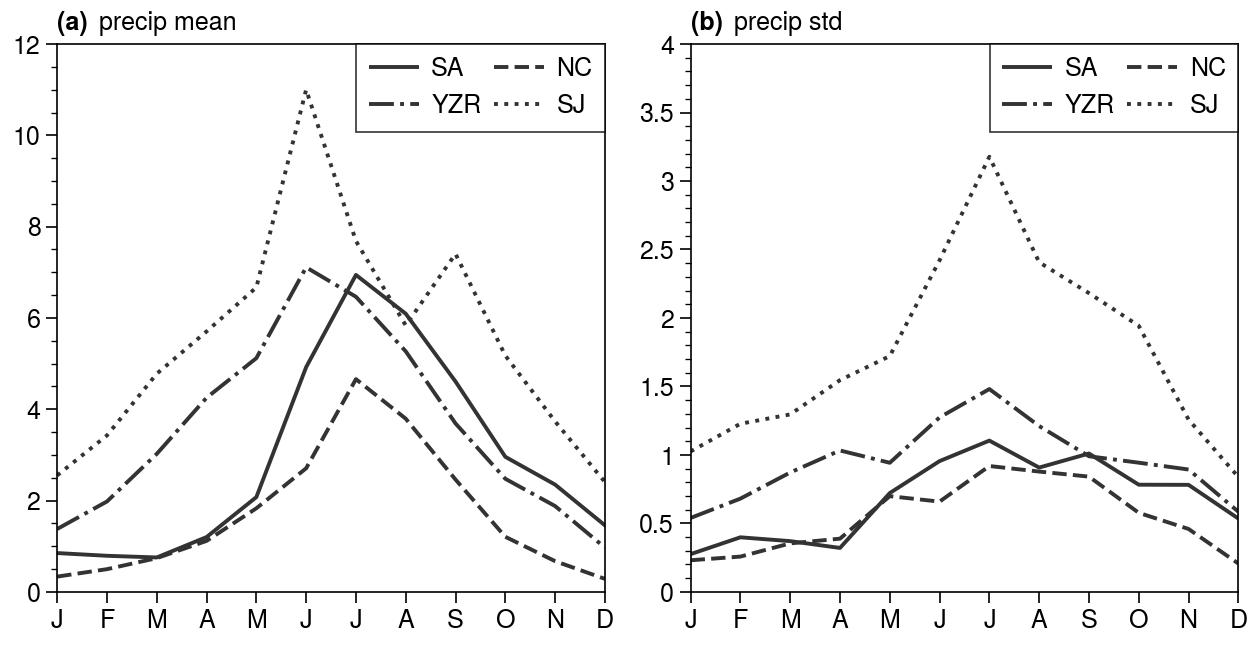

In [22]:
fig_plot_mon_cli = pplt.figure(span=False, share=False, figwidth="16cm")
axs = fig_plot_mon_cli.subplots(ncols=2, nrows=1)

axs[0].line(np.arange(1,13), preGPCP_India_mon_cli.mean(dim="time",skipna=True), color="#333333", linewidth=1.4)

axs[0].line(np.arange(1,13), preGPCP_NC_mon_cli.mean(dim="time",skipna=True), color="#333333", linewidth=1.4, linestyle="--")

axs[0].line(np.arange(1,13), preGPCP_YZR_mon_cli.mean(dim="time",skipna=True), color="#333333", linewidth=1.4, linestyle="-.")

axs[0].line(np.arange(1,13), preGPCP_SJ_mon_cli.mean(dim="time",skipna=True), color="#333333", linewidth=1.4, linestyle=":")

axs[1].line(np.arange(1,13), preGPCP_India_mon_cli.std(dim="time",skipna=True), color="#333333", linewidth=1.4)

axs[1].line(np.arange(1,13), preGPCP_NC_mon_cli.std(dim="time",skipna=True), color="#333333", linewidth=1.4, linestyle="--")

axs[1].line(np.arange(1,13), preGPCP_YZR_mon_cli.std(dim="time",skipna=True), color="#333333", linewidth=1.4, linestyle="-.")

axs[1].line(np.arange(1,13), preGPCP_SJ_mon_cli.std(dim="time",skipna=True), color="#333333", linewidth=1.4, linestyle=":")
axs[0].format(ylabel="", xticklabels=["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"], grid=False, xtickminor=False, xticks=np.arange(1,13), ylim=(0,12), ltitle="precip mean")
axs[1].format(ylabel="", xticklabels=["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"], grid=False, xtickminor=False, xticks=np.arange(1,13), ylim=(0,4), ltitle="precip std")
axs.legend(loc="upper right", labels=["SA", "NC", "YZR", "SJ"], ncols=2, handlelength=2.0, columnspacing=0.5, labelspacing=0.5)
fig_plot_mon_cli.format(abc="(a)", abcloc="l", rc_kw={"figure.facecolor":"white", "font.large": font_size})

## SASMR前两个主要模态（降水相关）

/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/hom

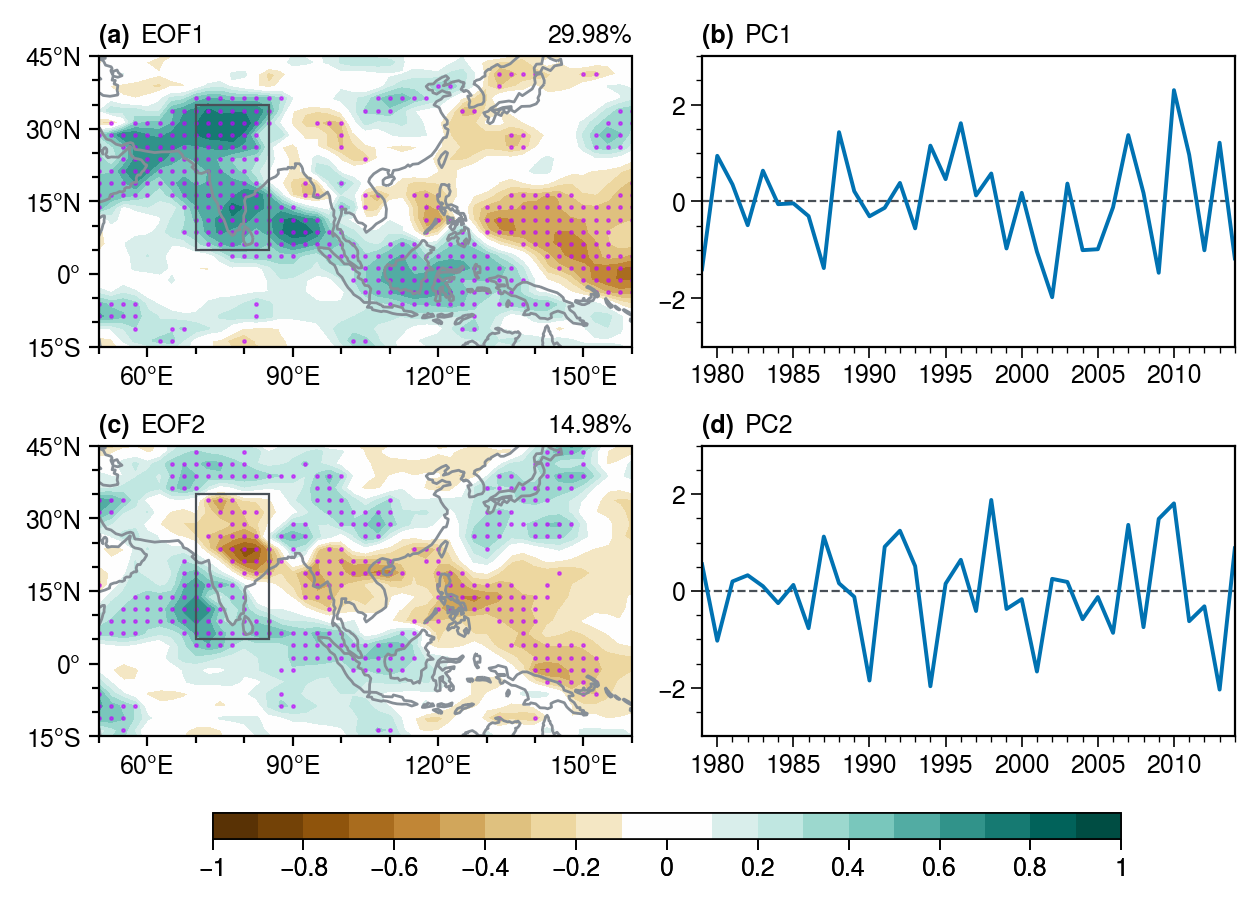

In [23]:
pplt.rc.reset()
pplt.rc.grid = False
# pplt.rc.reset()
cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

# fig_obs_pre_reg_diff_region = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=4.5, outerpad=2.0)
fig_pre_EOF = pplt.figure(span=False, share=False, figwidth="16cm", outerpad=1.0)
plot_array = np.reshape(range(1, 5), (2, 2))
axs = fig_pre_EOF.subplots(plot_array, proj=[proj, None, proj, None])

#   set the geo_ticks and map projection to the plots
xticks = np.array([60, 90, 120, 150])  # 设置纬度刻度
yticks = np.arange(-15, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [50.0, 160.0, yticks[0], 45.0]
sepl.geo_ticks(axs[:,0], xticks, yticks, cl, extents, majorticklabelsize=font_size, coastlinewidth=1.0, majorticklabelpad=3.0, majorticklen=3.5, minorticklen=2.5)

# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ===================================================
for ax in axs[:,0]:
  x0 = India_W
  y0 = India_S
  width = India_E-India_W
  height = India_N-India_S
  sepl.patches(ax, x0 - cl, y0, width, height, proj, linestyle="-", linewidth=0.8)
# ===================================================
con = axs[0,0].contourf(
    EOF_GPCP_pre_rvalue[0],
    cmap=prep_colormap,
    # cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1,1.1,0.1),
    zorder=0.8,
    # extend="both"
    )
sepl.plt_sig(
    EOF_GPCP_pre_rvalue[0], axs[0,0], n, np.where(EOF_GPCP_pre_pvalue[0][::n, ::n] < 0.10), "bright purple", 5.0,
)

axs[0,0].format(
    ltitle="EOF1", rtitle="{:.2f}%".format(preGPCP_India_percon[0]),
)
# ===================================================
axs[0,1].axhline(0, linewidth=0.8, color="grey7", ls="--")
axs[0,1].line(preGPCP_India_PCs.time.dt.year.data, preGPCP_India_PCs[:, 0], lw=1.4)
axs[0,1].format(ylim=(-3,3), ticklabelsize=font_size, ltitle="PC1")
# ===================================================
con = axs[1,0].contourf(
    EOF_GPCP_pre_rvalue[1],
    cmap=prep_colormap,
    # cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1,1.1,0.1),
    zorder=0.8,
    # extend="both"
    )
sepl.plt_sig(
    EOF_GPCP_pre_rvalue[1], axs[1,0], n, np.where(EOF_GPCP_pre_pvalue[1][::n, ::n] < 0.10), "bright purple", 5.0,
)

axs[1,0].format(
    ltitle="EOF2", rtitle="{:.2f}%".format(preGPCP_India_percon[1]),
)
# ===================================================
axs[1,1].axhline(0, linewidth=0.8, color="grey7", ls="--")
axs[1,1].line(preGPCP_India_PCs.time.dt.year.data, preGPCP_India_PCs[:, 1], lw=1.4)
axs[1,1].format(ylim=(-3,3), ticklabelsize=font_size, ltitle="PC2")
# ===================================================
cb = fig_pre_EOF.colorbar(con, loc="b", width=0.13, length=0.8, label="", ticklabelsize=font_size, pad=1.4)
axs.format(lw=0.8)
fig_pre_EOF.format(abc="(a)", abcloc="l", rc_kw={"grid": False, "reso": "lo", "figure.facecolor":"white", "font.large": font_size})
pplt.rc.reset()

## 观测夏季降水回归

/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/hom

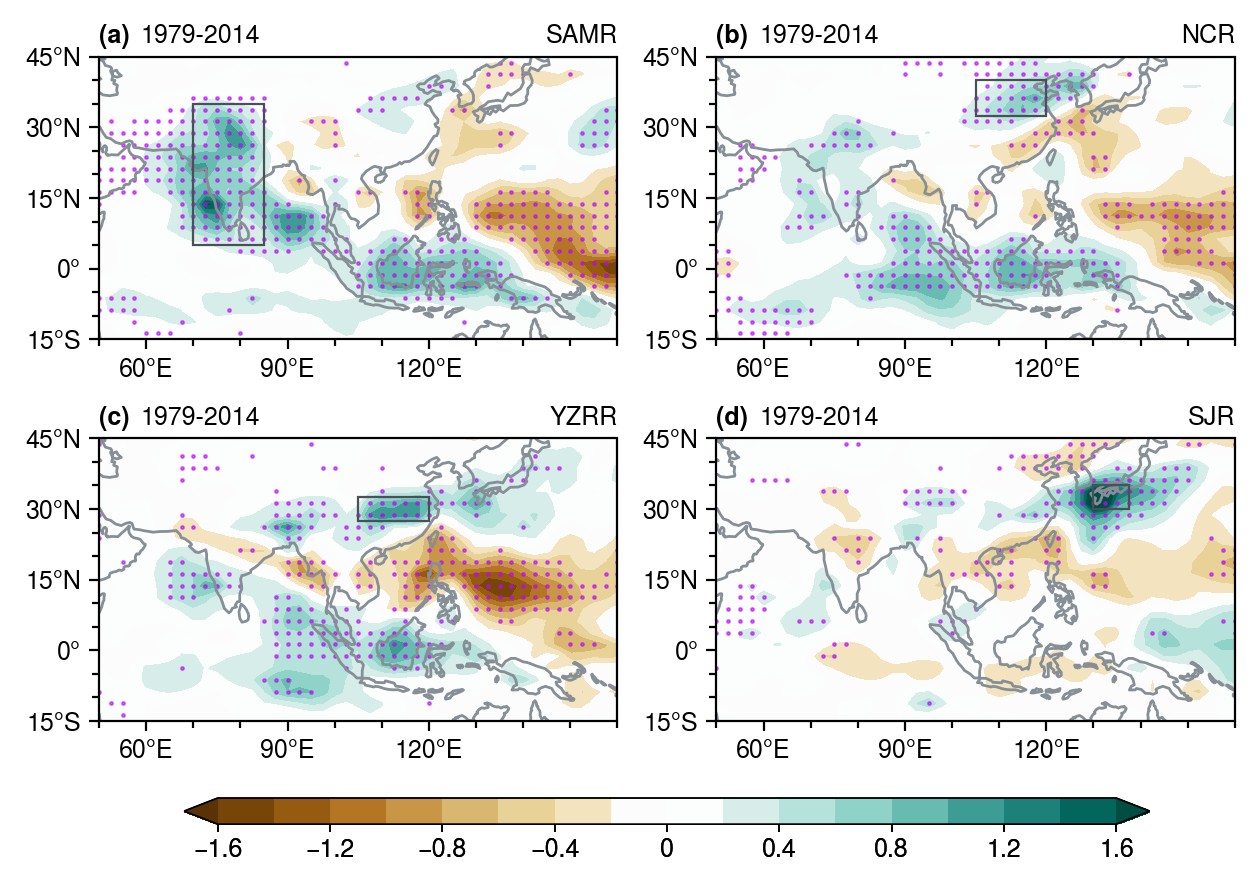

In [24]:
pplt.rc.reset()
pplt.rc.grid = False
# pplt.rc.reset()
cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

# fig_obs_pre_reg_diff_region = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=4.5, outerpad=2.0)
fig_obs_pre_reg_diff_region = pplt.figure(span=False, share=False, figwidth="16cm", outerpad=1.0)
plot_array = np.reshape(range(1, 5), (2, 2))
axs = fig_obs_pre_reg_diff_region.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(-15, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [50.0, 160.0, yticks[0], 45.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=font_size, coastlinewidth=1.0, majorticklabelpad=3.0, majorticklen=3.5, minorticklen=2.5)

# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ===================================================
x0 = India_W
y0 = India_S
width = India_E-India_W
height = India_N-India_S
sepl.patches(axs[0], x0 - cl, y0, width, height, proj, linestyle="-", linewidth=0.8)

x0 = NC_W
y0 = NC_S
width = NC_E-NC_W
height = NC_N-NC_S
sepl.patches(axs[1], x0 - cl, y0, width, height, proj, linestyle="-", linewidth=0.8)

x0 = YZR_W
y0 = YZR_S
width = YZR_E-YZR_W
height = YZR_N-YZR_S
sepl.patches(axs[2], x0 - cl, y0, width, height, proj, linestyle="-", linewidth=0.8)

x0 = SJ_W
y0 = SJ_S
width = SJ_E-SJ_W
height = SJ_N-SJ_S
sepl.patches(axs[3], x0 - cl, y0, width, height, proj, linestyle="-", linewidth=0.8)
# ===================================================
con = axs[0].contourf(
    IndR_GPCP_pre_slope,
    cmap=prep_colormap,
    # cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.6,1.7,0.2),
    zorder=0.8,
    extend="both"
    )
sepl.plt_sig(
    IndR_GPCP_pre_slope, axs[0], n, np.where(IndR_GPCP_pre_pvalue[::n, ::n] < 0.10), "bright purple", 5.0,
)

axs[0].format(
    ltitle="1979-2014", rtitle="SAMR",
)
# ===================================================
con = axs[1].contourf(
    NC_GPCP_pre_slope,
    cmap=prep_colormap,
    # cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.6,1.7,0.2),
    zorder=0.8,
    extend="both"
    )
sepl.plt_sig(
    NC_GPCP_pre_slope, axs[1], n, np.where(NC_GPCP_pre_pvalue[::n, ::n] < 0.10), "bright purple", 5.0,
)

axs[1].format(
    ltitle="1979-2014", rtitle="NCR",
)
# ===================================================
con = axs[2].contourf(
    YZR_GPCP_pre_slope,
    cmap=prep_colormap,
    # cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.6,1.7,0.2),
    zorder=0.8,
    extend="both"
    )
sepl.plt_sig(
    YZR_GPCP_pre_slope, axs[2], n, np.where(YZR_GPCP_pre_pvalue[::n, ::n] < 0.10), "bright purple", 5.0,
)

axs[2].format(
    ltitle="1979-2014", rtitle="YZRR",
)
# ===================================================
con = axs[3].contourf(
    SJ_GPCP_pre_slope,
    cmap=prep_colormap,
    # cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.6,1.7,0.2),
    zorder=0.8,
    extend="both"
    )
sepl.plt_sig(
    SJ_GPCP_pre_slope, axs[3], n, np.where(SJ_GPCP_pre_pvalue[::n, ::n] < 0.10), "bright purple", 5.0,
)

axs[3].format(
    ltitle="1979-2014", rtitle="SJR",
)
# ===================================================
cb = fig_obs_pre_reg_diff_region.colorbar(con, loc="b", width=0.13, length=0.85, label="", ticklabelsize=font_size, pad=1.4, ticklen=3.0)
cb.set_ticks(np.arange(-1.6,1.7,0.4))
axs.format(linewidth=0.8)
fig_obs_pre_reg_diff_region.format(abc="(a)", abcloc="l", rc_kw={"grid": False, "reso": "lo", "figure.facecolor":"white", "font.large": font_size})
# fig_obs_pre_reg_diff_region.save("/home/ys17-23/chenhj/Chen_etal_2023_fig/fig_1.ps", dpi=300)
# fig_obs_pre_reg_diff_region.save("/home/ys17-23/chenhj/Chen_etal_2023_fig/fig_1_7.5pt.svg", dpi=300)
pplt.rc.reset()

## 分月份相关折线图

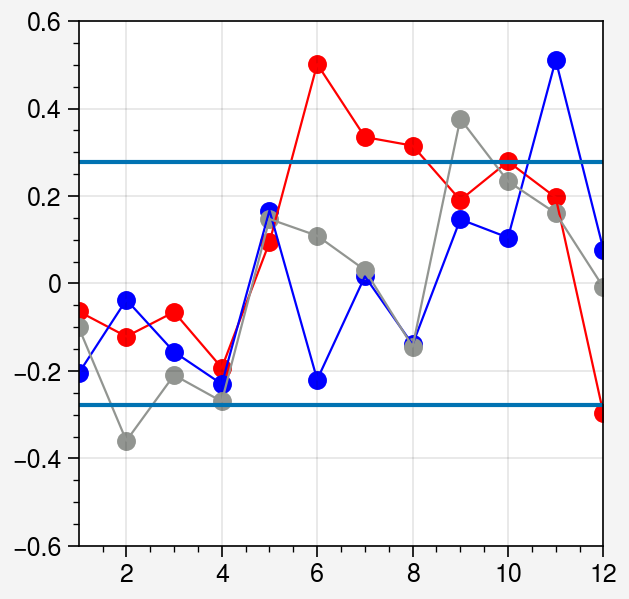

In [25]:
fig_plot_mon = pplt.figure(span=False, share=False, figwidth="8cm")
axs = fig_plot_mon.subplots(ncols=1, nrows=1)

axs[0].line(np.arange(1,13), IndR_NC_mon_rvalue, color="red", linewidth=0.8)
axs[0].scatter(np.arange(1,13), IndR_NC_mon_rvalue, color="red", linewidth=0.8)

axs[0].line(np.arange(1,13), IndR_SJ_mon_rvalue, color="blue", linewidth=0.8)
axs[0].scatter(np.arange(1,13), IndR_SJ_mon_rvalue, color="blue", linewidth=0.8)

axs[0].line(np.arange(1,13), IndR_YZR_mon_rvalue, color="grey", linewidth=0.8)
axs[0].scatter(np.arange(1,13), IndR_YZR_mon_rvalue, color="grey", linewidth=0.8)

axs[0].axhline(ca.cal_rlim(36, clevel=0.9))
axs[0].axhline(-ca.cal_rlim(36, clevel=0.9))
axs.format(ylim=(-0.6,0.6),ylabel="", ltitle="")

## 200-hPa环流回归到印度半岛降水、北部降水、华北降水和气候态西风急流

/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/hom

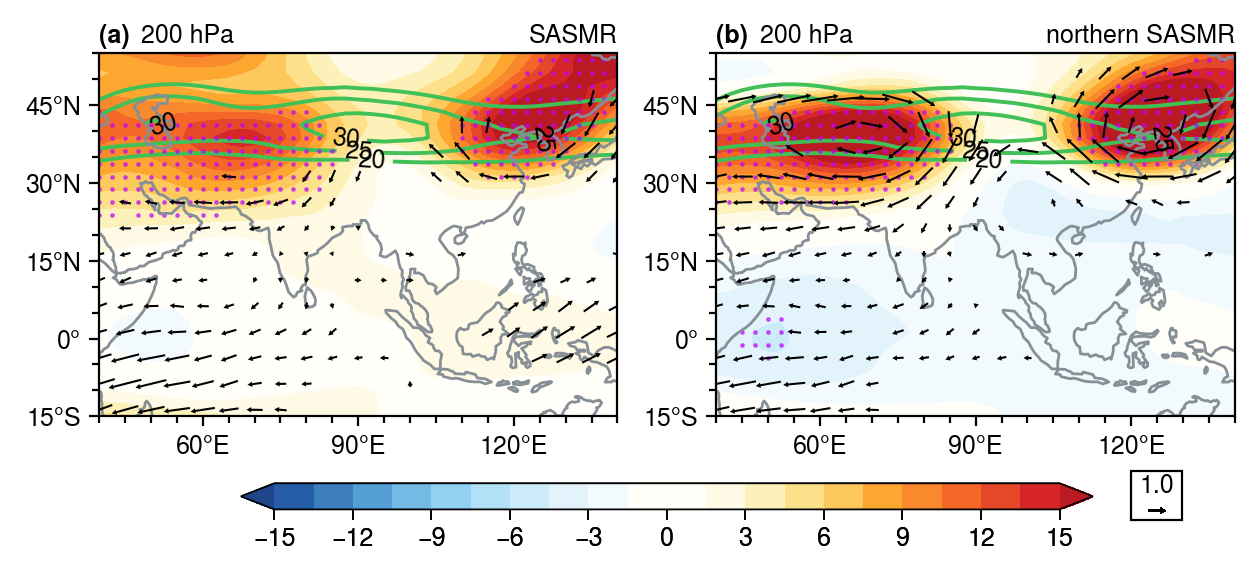

In [43]:
pplt.rc.reset()
pplt.rc.grid = False
startlevel=[-15, -8, -6]
spacinglevel=[1.5, 0.8, 0.6]
scalelevel=[0.30, 0.17, 0.14]

cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

# fig2 = pplt.figure(span=False, share=False, refwidth=6.0, wspace=6.0, hspace=5.5, outerpad=2.0)
fig_200_cir_reg = pplt.figure(span=False, share=False, figwidth="16cm", hspace=3.0, outerpad=1.0)
plot_array = np.reshape(range(1, 3), (1, 2))
# plot_array[-1,-1] = 0
axs = fig_200_cir_reg.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(-15, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=font_size, lonminorspace=5, coastlinewidth=1.0, majorticklabelpad=3.0, majorticklen=3.5, minorticklen=2.5)
# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ===================================================
for num_lev,lev in enumerate([200.0]):
    con = axs[0].contourf(
        IndR_ERA5_hgt_slope.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        IndR_ERA5_hgt_slope.sel(level=lev), axs[0], n, np.where(IndR_ERA5_hgt_pvalue.sel(level=lev)[::n, ::n] <= 0.05), "bright purple", 5.0,
    )

    m = axs[0].quiver(
        IndR_ERA5_uJJA_slope.sel(level=lev).where(IndR_ERA5_windJJA_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        IndR_ERA5_vJJA_slope.sel(level=lev).where(IndR_ERA5_windJJA_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )
    CS = axs[0].contour(
      uERA5_ver_JJA_cli.sel(level=200.0).mean(dim="time",skipna=True),
      color="green6",
      levels=np.array([20.0, 25.0, 30.0]),
      zorder=0.8,
      lw=1.4
    )
    sepl.contour_label(axs[0], CS, inline_spacing=3, fontsize=font_size, colors="k")
    # qk = axs[0].quiverkey(
    #     m, X=1 - w / 2, Y=0.80 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.035, fontproperties={"size": 7.5}, zorder=3.1,
    # )
    axs[0].format(
        ltitle="{:.0f} hPa".format(lev), rtitle="SASMR",
    )
    # ======================================
    con = axs[1].contourf(
        nIndR_ERA5_hgt_slope.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        nIndR_ERA5_hgt_slope.sel(level=lev), axs[1], n, np.where(nIndR_ERA5_hgt_pvalue.sel(level=lev)[::n, ::n] <= 0.05), "bright purple", 5.0,
    )

    m = axs[1].quiver(
        nIndR_ERA5_uJJA_slope.sel(level=lev).where(nIndR_ERA5_windJJA_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        nIndR_ERA5_vJJA_slope.sel(level=lev).where(nIndR_ERA5_windJJA_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    # qk = axs[1].quiverkey(
    #     m, X=1 - w / 2, Y=0.80 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.035, fontproperties={"size": 7.5}, zorder=3.1,
    # )
    axs[1].format(
        ltitle="{:.0f} hPa".format(lev), rtitle="northern SASMR",
    )
    CS = axs[1].contour(
      uERA5_ver_JJA_cli.sel(level=200.0).mean(dim="time",skipna=True),
      color="green6",
      levels=np.array([20.0, 25.0, 30.0]),
      zorder=0.8,
      lw=1.4
    )
    sepl.contour_label(axs[1], CS, inline_spacing=3, fontsize=font_size, colors="k")
scale_ref = 1.0
qk = axs[1].quiverkey(m, 0.85, -0.26, scale_ref, str(scale_ref)+'', labelpos='N', labelsep=0.06, coordinates='axes', fontproperties={"size": font_size})

rect = Rectangle((0.898, 0.095), 0.04, 0.085, transform=fig_200_cir_reg.transFigure, fc="none", ec="k", lw=0.8, zorder=1.1)
fig_200_cir_reg.add_artist(rect)
    # ======================================
    # con = axs[2].contourf(
    #     EOF_ERA5_hgt_slope[0].sel(level=lev),
    #     cmap="ColdHot",
    #     cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    #     levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
    #     zorder=0.8,
    #     extend="both"
    # )
    # sepl.plt_sig(
    #     EOF_ERA5_hgt_slope[0].sel(level=lev), axs[2], n, np.where(EOF_ERA5_hgt_pvalue[0].sel(level=lev)[::n, ::n] <= 0.05), "bright purple", 3.0,
    # )

    # m = axs[2].quiver(
    #     EOF_ERA5_uJJA_slope[0].sel(level=lev).where(EOF_ERA5_windJJA_mask[0].sel(level=lev) > 0.0)[::ski, ::ski],
    #     EOF_ERA5_vJJA_slope[0].sel(level=lev).where(EOF_ERA5_windJJA_mask[0].sel(level=lev) > 0.0)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     minlength=0.5,
    #     width=0.004,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="black",
    # )

    # # qk = axs[2].quiverkey(
    # #     m, X=1 - w / 2, Y=0.80 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.035, fontproperties={"size": 7.5}, zorder=3.1,
    # # )
    # axs[2].format(
    #     ltitle="{:.0f} hPa".format(lev), rtitle="PC1",
    # )
    # # ======================================
    # con = axs[3].contourf(
    #     -EOF_ERA5_hgt_slope[1].sel(level=lev),
    #     cmap="ColdHot",
    #     cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    #     levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
    #     zorder=0.8,
    #     extend="both"
    # )
    # sepl.plt_sig(
    #     -EOF_ERA5_hgt_slope[1].sel(level=lev), axs[3], n, np.where(EOF_ERA5_hgt_pvalue[1].sel(level=lev)[::n, ::n] <= 0.05), "bright purple", 3.0,
    # )

    # m = axs[3].quiver(
    #     -EOF_ERA5_uJJA_slope[1].sel(level=lev).where(EOF_ERA5_windJJA_mask[1].sel(level=lev) > 0.0)[::ski, ::ski],
    #     -EOF_ERA5_vJJA_slope[1].sel(level=lev).where(EOF_ERA5_windJJA_mask[1].sel(level=lev) > 0.0)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     minlength=0.5,
    #     width=0.004,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="black",
    # )

    # # qk = axs[3].quiverkey(
    # #     m, X=1 - w / 2, Y=0.80 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.035, fontproperties={"size": 7.5}, zorder=3.1,
    # # )
    # axs[3].format(
    #     ltitle="{:.0f} hPa".format(lev), rtitle="PC2",
    # )

axs.format(linewidth=0.8, titlepad=4.0)
cb = fig_200_cir_reg.colorbar(con, loc="b", width=0.13, length=0.75, label="", ticklabelsize=font_size)
# qk = plt.quiverkey(
#     m, X=rectx0+0.5*rectw, Y=recty0+recth*0.2, U=1.0, label="1.0", labelpos="N", labelsep=0.06, fontproperties={"size": font_size}, zorder=3.1, coordinates="figure"
# )
# fig_200_cir_reg.add_artist(qk)

fig_200_cir_reg.format(abc="(a)", abcloc="l", rc_kw={"grid": False, "reso":"lo", "figure.facecolor":"white", "font.large":font_size})
pplt.rc.reset()

In [ ]:
pplt.rc.reset()
pplt.rc.grid = False
startlevel=[-15, -8, -6]
spacinglevel=[1.5, 0.8, 0.6]
scalelevel=[0.30, 0.17, 0.14]

cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

# fig2 = pplt.figure(span=False, share=False, refwidth=6.0, wspace=6.0, hspace=5.5, outerpad=2.0)
fig_200_cir_reg = pplt.figure(span=False, share=False, figwidth="16cm", hspace=3.0, outerpad=1.0)
plot_array = np.reshape(range(1, 5), (2, 2))
# plot_array[-1,-1] = 0
axs = fig_200_cir_reg.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(-15, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=font_size, lonminorspace=5, coastlinewidth=1.0, majorticklabelpad=3.0, majorticklen=3.5, minorticklen=2.5)
# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ===================================================
for num_lev,lev in enumerate([200.0]):
    con = axs[0].contourf(
        IndR_ERA5_hgt_slope.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        IndR_ERA5_hgt_slope.sel(level=lev), axs[0], n, np.where(IndR_ERA5_hgt_pvalue.sel(level=lev)[::n, ::n] <= 0.05), "bright purple", 5.0,
    )

    m = axs[0].quiver(
        IndR_ERA5_uJJA_slope.sel(level=lev).where(IndR_ERA5_windJJA_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        IndR_ERA5_vJJA_slope.sel(level=lev).where(IndR_ERA5_windJJA_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )
    CS = axs[0].contour(
      uERA5_ver_JJA_cli.sel(level=200.0).mean(dim="time",skipna=True),
      color="green6",
      levels=np.array([20.0, 25.0, 30.0]),
      zorder=0.8,
      lw=1.4
    )
    sepl.contour_label(axs[0], CS, inline_spacing=3, fontsize=font_size, colors="k")
    # qk = axs[0].quiverkey(
    #     m, X=1 - w / 2, Y=0.80 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.035, fontproperties={"size": 7.5}, zorder=3.1,
    # )
    axs[0].format(
        ltitle="{:.0f} hPa".format(lev), rtitle="SASMR",
    )
    # ======================================
    con = axs[1].contourf(
        nIndR_ERA5_hgt_slope.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        nIndR_ERA5_hgt_slope.sel(level=lev), axs[1], n, np.where(nIndR_ERA5_hgt_pvalue.sel(level=lev)[::n, ::n] <= 0.05), "bright purple", 5.0,
    )

    m = axs[1].quiver(
        nIndR_ERA5_uJJA_slope.sel(level=lev).where(nIndR_ERA5_windJJA_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        nIndR_ERA5_vJJA_slope.sel(level=lev).where(nIndR_ERA5_windJJA_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    # qk = axs[1].quiverkey(
    #     m, X=1 - w / 2, Y=0.80 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.035, fontproperties={"size": 7.5}, zorder=3.1,
    # )
    axs[1].format(
        ltitle="{:.0f} hPa".format(lev), rtitle="northern SASMR",
    )
    CS = axs[1].contour(
      uERA5_ver_JJA_cli.sel(level=200.0).mean(dim="time",skipna=True),
      color="green6",
      levels=np.array([20.0, 25.0, 30.0]),
      zorder=0.8,
      lw=1.4
    )
    sepl.contour_label(axs[1], CS, inline_spacing=3, fontsize=font_size, colors="k")

    # ======================================
    con = axs[2].contourf(
        EOF_ERA5_hgt_slope[0].sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        EOF_ERA5_hgt_slope[0].sel(level=lev), axs[2], n, np.where(EOF_ERA5_hgt_pvalue[0].sel(level=lev)[::n, ::n] <= 0.05), "bright purple", 3.0,
    )

    m = axs[2].quiver(
        EOF_ERA5_uJJA_slope[0].sel(level=lev).where(EOF_ERA5_windJJA_mask[0].sel(level=lev) > 0.0)[::ski, ::ski],
        EOF_ERA5_vJJA_slope[0].sel(level=lev).where(EOF_ERA5_windJJA_mask[0].sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )

    # qk = axs[2].quiverkey(
    #     m, X=1 - w / 2, Y=0.80 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.035, fontproperties={"size": 7.5}, zorder=3.1,
    # )
    CS = axs[2].contour(
      uERA5_ver_JJA_cli.sel(level=200.0).mean(dim="time",skipna=True),
      color="green6",
      levels=np.array([20.0, 25.0, 30.0]),
      zorder=0.8,
      lw=1.4
    )
    sepl.contour_label(axs[2], CS, inline_spacing=3, fontsize=font_size, colors="k")
    axs[2].format(
        ltitle="{:.0f} hPa".format(lev), rtitle="PC1",
    )
    # ======================================
    con = axs[3].contourf(
        -EOF_ERA5_hgt_slope[1].sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        -EOF_ERA5_hgt_slope[1].sel(level=lev), axs[3], n, np.where(EOF_ERA5_hgt_pvalue[1].sel(level=lev)[::n, ::n] <= 0.05), "bright purple", 3.0,
    )

    m = axs[3].quiver(
        -EOF_ERA5_uJJA_slope[1].sel(level=lev).where(EOF_ERA5_windJJA_mask[1].sel(level=lev) > 0.0)[::ski, ::ski],
        -EOF_ERA5_vJJA_slope[1].sel(level=lev).where(EOF_ERA5_windJJA_mask[1].sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[num_lev],
        pivot="mid",
        color="black",
    )
    
    CS = axs[3].contour(
      uERA5_ver_JJA_cli.sel(level=200.0).mean(dim="time",skipna=True),
      color="green6",
      levels=np.array([20.0, 25.0, 30.0]),
      zorder=0.8,
      lw=1.4
    )
    sepl.contour_label(axs[3], CS, inline_spacing=3, fontsize=font_size, colors="k")
    axs[3].format(
        ltitle="{:.0f} hPa".format(lev), rtitle="PC2",
    )
    
scale_ref = 1.0
qk = axs[3].quiverkey(m, 0.85, -0.26, scale_ref, str(scale_ref)+'', labelpos='N', labelsep=0.06, coordinates='axes', fontproperties={"size": font_size})

rect = Rectangle((0.9, 0.05), 0.038, 0.06, transform=fig_200_cir_reg.transFigure, fc="none", ec="k", lw=0.8, zorder=1.1)
fig_200_cir_reg.add_artist(rect)
    # qk = axs[3].quiverkey(
    #     m, X=1 - w / 2, Y=0.80 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.035, fontproperties={"size": 7.5}, zorder=3.1,
    # )

axs.format(linewidth=0.8, titlepad=4.0)
cb = fig_200_cir_reg.colorbar(con, loc="b", width=0.13, length=0.75, label="", ticklabelsize=font_size)
# qk = plt.quiverkey(
#     m, X=rectx0+0.5*rectw, Y=recty0+recth*0.2, U=1.0, label="1.0", labelpos="N", labelsep=0.06, fontproperties={"size": font_size}, zorder=3.1, coordinates="figure"
# )
# fig_200_cir_reg.add_artist(qk)

fig_200_cir_reg.format(abc="(a)", abcloc="l", rc_kw={"grid": False, "reso":"lo", "figure.facecolor":"white", "font.large":font_size})
pplt.rc.reset()

## 降水回归到北部降水、200-hPa散度、850-hPa散度和风场、850-hPa垂直积分水汽通量和水汽通量散度

/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/hom

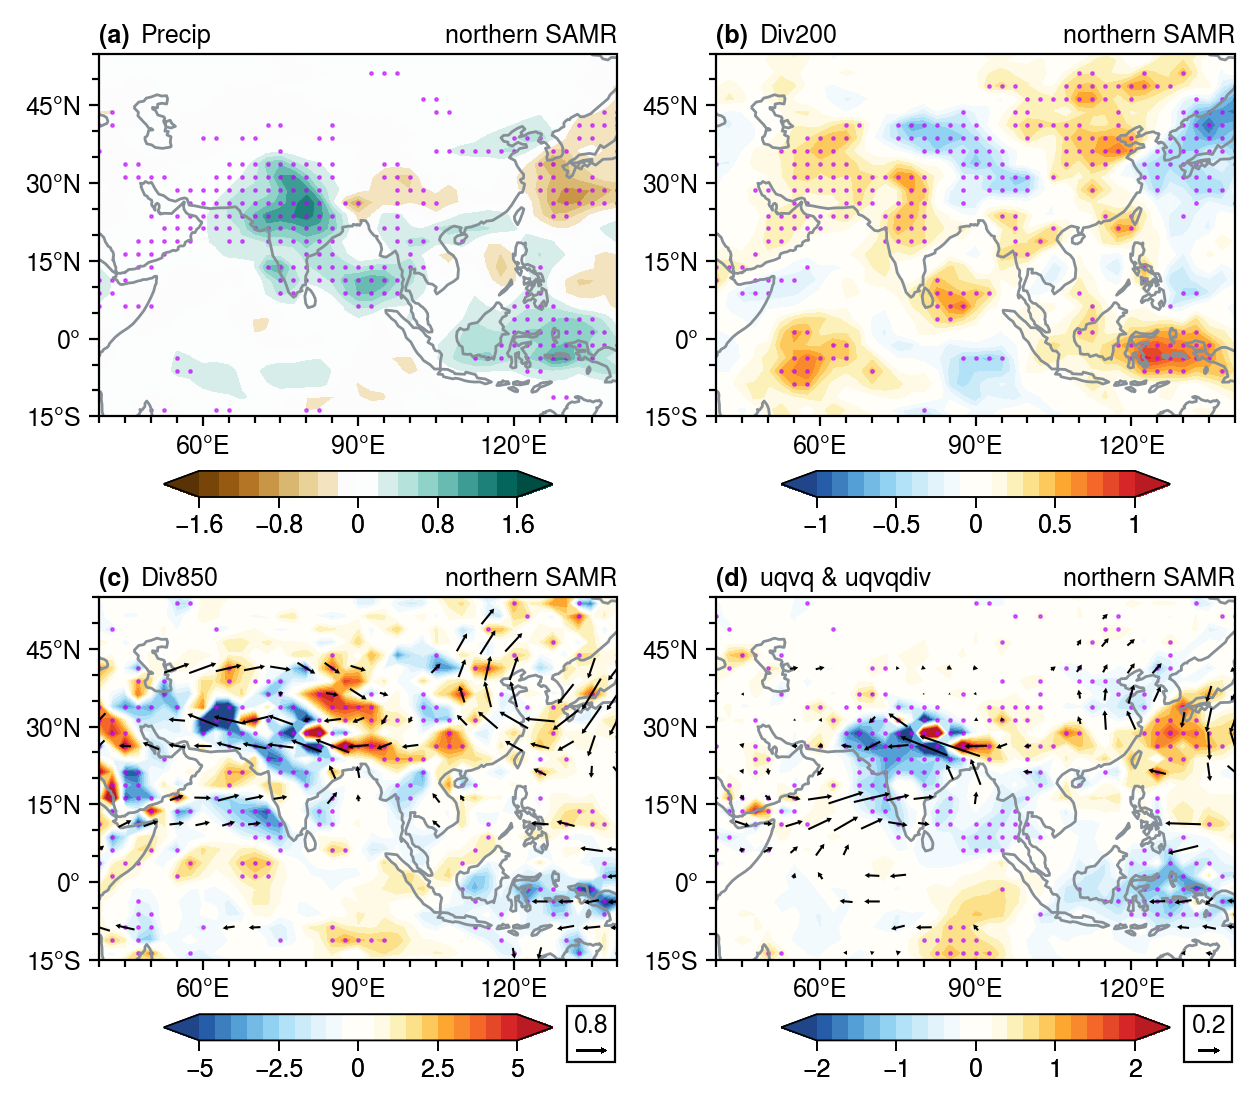

In [27]:
pplt.rc.reset()
pplt.rc.grid = False
startlevel=[-15, -8, -6]
spacinglevel=[1.5, 0.8, 0.6]
scalelevel=[0.30, 0.17, 0.14]
divstartlevel = [-1, -5]
divspacinglevel=[1e-1, 5e-1]
uqvqdivstartlevel = -2
uqvqdivspacinglevel = 0.2
uqvqdivscale=0.05

cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

# fig2 = pplt.figure(span=False, share=False, refwidth=6.0, wspace=6.0, hspace=5.5, outerpad=2.0)
fig_pre_200_850div_water = pplt.figure(span=False, share=False, figwidth="16cm", hspace=4.0, outerpad=1.0)
axs = fig_pre_200_850div_water.subplots(ncols=2, nrows=2, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(-15, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=font_size, lonminorspace=5, coastlinewidth=1.0, majorticklabelpad=3.0, majorticklen=3.5, minorticklen=2.5)
# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ===================================================
con = axs[0].contourf(
    nIndR_GPCP_pre_slope,
    cmap=prep_colormap,
    # cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.6,1.7,0.2),
    zorder=0.8,
    extend="both"
    )
sepl.plt_sig(
    nIndR_GPCP_pre_slope, axs[0], n, np.where(nIndR_GPCP_pre_pvalue[::n, ::n] < 0.10), "bright purple", 5.0,
)

axs[0].format(
    ltitle="Precip", rtitle="northern SAMR",
)
axs[0].colorbar(con, loc="b", width=0.13, length=0.75, label="", ticklabelsize=font_size)
# ===================================================
con = axs[1].contourf(
    nIndR_ERA5_div_slope.sel(level=200.0)*1e6,
    levels=np.arange(divstartlevel[0], -divstartlevel[0]+divspacinglevel[0], divspacinglevel[0]),
    zorder=0.8,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    extend="both"
    )
sepl.plt_sig(
    nIndR_ERA5_div_slope.sel(level=200.0), axs[1], n, np.where(nIndR_ERA5_div_pvalue.sel(level=200.0)[::n, ::n] < 0.10), "bright purple", 5.0,
)

axs[1].format(
    ltitle="Div200", rtitle="northern SAMR",
)
axs[1].colorbar(con, loc="b", width=0.13, length=0.75, label="", ticklabelsize=font_size)
# ===================================================
con = axs[2].contourf(
    nIndR_ERA5_div_slope.sel(level=850.0)*1e7,
    levels=np.arange(divstartlevel[1], -divstartlevel[1]+divspacinglevel[1], divspacinglevel[1]),
    zorder=0.8,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    extend="both"
    )
sepl.plt_sig(
    nIndR_ERA5_div_slope.sel(level=850.0), axs[2], n, np.where(nIndR_ERA5_div_pvalue.sel(level=850.0)[::n, ::n] < 0.10), "bright purple", 5.0,
)

axs[2].format(
    ltitle="Div850", rtitle="northern SAMR",
)
axs[2].colorbar(con, loc="b", width=0.13, length=0.75, label="", ticklabelsize=font_size)

m = axs[2].quiver(
        nIndR_ERA5_uJJA_slope.sel(level=850).where(nIndR_ERA5_windJJA_mask.sel(level=850) > 0.0)[::ski, ::ski],
        nIndR_ERA5_vJJA_slope.sel(level=850).where(nIndR_ERA5_windJJA_mask.sel(level=850) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[2],
        pivot="mid",
        color="black",
    )
scale_ref = 0.8
qk = axs[2].quiverkey(m, 0.95, -0.25, scale_ref, str(scale_ref)+'', labelpos='N', labelsep=0.06, coordinates='axes', fontproperties={"size": font_size})
rect = Rectangle((0.45,0.04), 0.038, 0.05, transform=fig_pre_200_850div_water.transFigure, fc="none", ec="k", lw=0.8, zorder=100.1)
fig_pre_200_850div_water.add_artist(rect)
# ===================================================
con = axs[3].contourf(
    nIndR_ERA5_uqvqdiv_slope*1e7,
    levels=np.arange(uqvqdivstartlevel, -uqvqdivstartlevel+uqvqdivspacinglevel, uqvqdivspacinglevel),
    zorder=0.8,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    extend="both"
    )
sepl.plt_sig(
    nIndR_ERA5_uqvqdiv_slope, axs[3], n, np.where(nIndR_ERA5_uqvqdiv_pvalue[::n, ::n] < 0.10), "bright purple", 5.0,
)
m = axs[3].quiver(
      nIndR_ERA5_uq_slope.where(nIndR_ERA5_uqvq_mask > 0.0)[::ski, ::ski],
      nIndR_ERA5_vq_slope.where(nIndR_ERA5_uqvq_mask > 0.0)[::ski, ::ski],
      zorder=1.1,
      headwidth=2.6,
      headlength=2.3,
      headaxislength=2.3,
      minlength=0.5,
      width=0.004,
      scale_units="xy",
      scale=uqvqdivscale,
      pivot="mid",
      color="black",
    )
axs[3].format(
    ltitle="uqvq & uqvqdiv", rtitle="northern SAMR",
)
scale_ref = 0.2
qk = axs[3].quiverkey(m, 0.95, -0.25, scale_ref, str(scale_ref)+'', labelpos='N', labelsep=0.06, coordinates='axes', fontproperties={"size": font_size})

rect = Rectangle((0.94,0.04), 0.038, 0.05, transform=fig_pre_200_850div_water.transFigure, fc="none", ec="k", lw=0.8, zorder=100.1)
fig_pre_200_850div_water.add_artist(rect)


cb = axs[3].colorbar(con, loc="b", width=0.13, length=0.75, label="", ticklabelsize=font_size)

# cborientation = cb.ax.get_position(original=True)
# cbx, cby, cbw, cbh = cborientation.x0, cborientation.y0, cborientation.width, cborientation.height
# rectx0 = cbx+cbw+0.008
# recty0 = 0.085
# rextx0 = -5
# recty0 = 0.05
# rectw = 0.08
# recth = 0.06
# rect = Rectangle((rectx0, recty0), rectw, recth, transform=fig_pre_200_850div_water.transFigure, fc="white", ec="k", lw=0.8, zorder=1.1)
# fig_pre_200_850div_water.add_artist(rect)
# qk = plt.quiverkey(
#     m, X=rectx0+0.5*rectw, Y=recty0+recth*0.2, U=0.5, label="1.0", labelpos="N", labelsep=0.06, fontproperties={"size": font_size}, zorder=3.1, coordinates="figure"
# )
# fig_pre_200_850div_water.add_artist(qk)



# ===================================================
axs.format(linewidth=0.8, titlepad=4.0)

# cborientation = cb.ax.get_position(original=True)
# cbx, cby, cbw, cbh = cborientation.x0, cborientation.y0, cborientation.width, cborientation.height
# rectx0 = cbx+cbw+0.008
# recty0 = 0.085
# rectw = 0.055
# recth = 0.09
# rect = Rectangle((rectx0, recty0), rectw, recth, transform=fig_pre_200_850div_water.transFigure, fc="white", ec="k", lw=0.8, zorder=1.1)
# fig_pre_200_850div_water.add_artist(rect)
# qk = plt.quiverkey(
#     m, X=rectx0+0.5*rectw, Y=recty0+recth*0.2, U=1.0, label="1.0", labelpos="N", labelsep=0.06, fontproperties={"size": font_size}, zorder=3.1, coordinates="figure"
# )
# fig_pre_200_850div_water.add_artist(qk)

fig_pre_200_850div_water.format(abc="(a)", abcloc="l", rc_kw={"grid": False, "reso":"lo", "figure.facecolor":"white", "font.large":font_size})
pplt.rc.reset()

##  850-hPa环流回归到印度半岛降水、南部降水

/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/hom

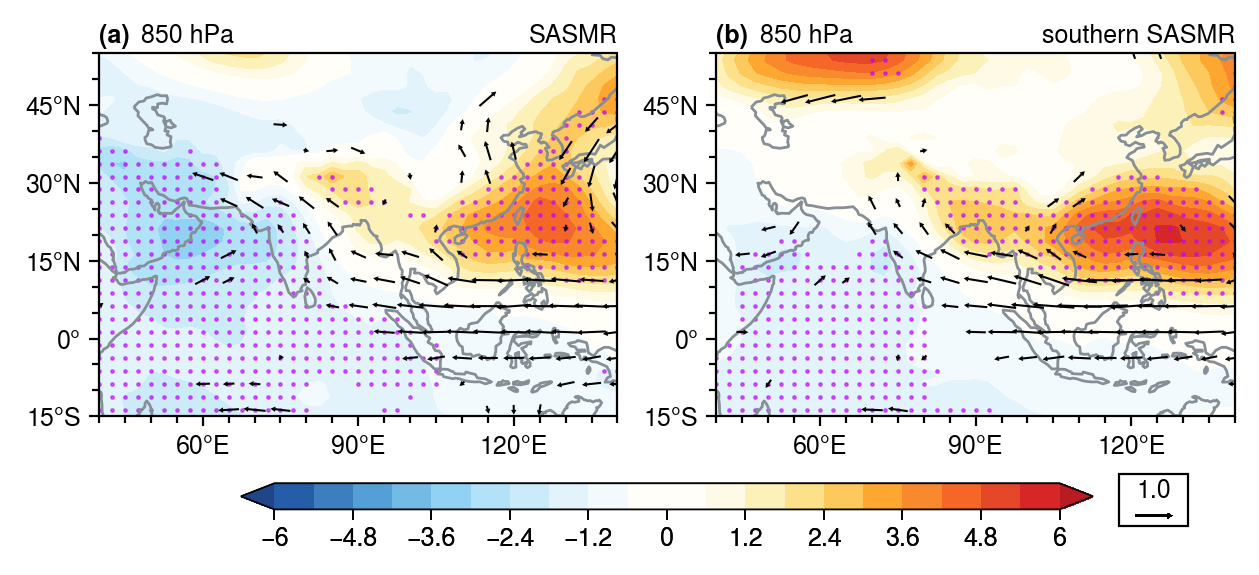

In [44]:
pplt.rc.reset()
pplt.rc.grid = False
startlevel=[-15, -8, -6]
spacinglevel=[1.5, 0.8, 0.6]
scalelevel=[0.30, 0.17, 0.14]

cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

# fig2 = pplt.figure(span=False, share=False, refwidth=6.0, wspace=6.0, hspace=5.5, outerpad=2.0)
fig_850_cir_reg = pplt.figure(span=False, share=False, figwidth="16cm", hspace=3.0, outerpad=1.0)
plot_array = np.reshape(range(1, 3), (1, 2))
# plot_array[-1,-1] = 0
axs = fig_850_cir_reg.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(-15, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=font_size, lonminorspace=5, coastlinewidth=1.0, majorticklabelpad=3.0, majorticklen=3.5, minorticklen=2.5)
# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ===================================================
for num_lev,lev in enumerate([850.0]):
    con = axs[0].contourf(
        IndR_ERA5_hgt_slope.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[-1], -startlevel[-1]+spacinglevel[-1], spacinglevel[-1]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        IndR_ERA5_hgt_slope.sel(level=lev), axs[0], n, np.where(IndR_ERA5_hgt_pvalue.sel(level=lev)[::n, ::n] <= 0.05), "bright purple", 5.0,
    )

    m = axs[0].quiver(
        IndR_ERA5_uJJA_slope.sel(level=lev).where(IndR_ERA5_windJJA_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        IndR_ERA5_vJJA_slope.sel(level=lev).where(IndR_ERA5_windJJA_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[-1],
        pivot="mid",
        color="black",
    )

    # qk = axs[0].quiverkey(
    #     m, X=1 - w / 2, Y=0.80 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.035, fontproperties={"size": 7.5}, zorder=3.1,
    # )
    axs[0].format(
        ltitle="{:.0f} hPa".format(lev), rtitle="SASMR",
    )
    # ======================================
    con = axs[1].contourf(
        sIndR_ERA5_hgt_slope.sel(level=lev),
        cmap="ColdHot",
        cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
        levels=np.arange(startlevel[-1], -startlevel[-1]+spacinglevel[-1], spacinglevel[-1]),
        zorder=0.8,
        extend="both"
    )
    sepl.plt_sig(
        sIndR_ERA5_hgt_slope.sel(level=lev), axs[1], n, np.where(sIndR_ERA5_hgt_pvalue.sel(level=lev)[::n, ::n] <= 0.05), "bright purple", 5.0,
    )

    m = axs[1].quiver(
        sIndR_ERA5_uJJA_slope.sel(level=lev).where(sIndR_ERA5_windJJA_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        sIndR_ERA5_vJJA_slope.sel(level=lev).where(sIndR_ERA5_windJJA_mask.sel(level=lev) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[-1],
        pivot="mid",
        color="black",
    )

    # qk = axs[1].quiverkey(
    #     m, X=1 - w / 2, Y=0.80 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.035, fontproperties={"size": 7.5}, zorder=3.1,
    # )
    axs[1].format(
        ltitle="{:.0f} hPa".format(lev), rtitle="southern SASMR",
    )
    # ======================================
    # con = axs[2].contourf(
    #     EOF_ERA5_hgt_slope[0].sel(level=lev),
    #     cmap="ColdHot",
    #     cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    #     levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
    #     zorder=0.8,
    #     extend="both"
    # )
    # sepl.plt_sig(
    #     EOF_ERA5_hgt_slope[0].sel(level=lev), axs[2], n, np.where(EOF_ERA5_hgt_pvalue[0].sel(level=lev)[::n, ::n] <= 0.05), "bright purple", 3.0,
    # )

    # m = axs[2].quiver(
    #     EOF_ERA5_uJJA_slope[0].sel(level=lev).where(EOF_ERA5_windJJA_mask[0].sel(level=lev) > 0.0)[::ski, ::ski],
    #     EOF_ERA5_vJJA_slope[0].sel(level=lev).where(EOF_ERA5_windJJA_mask[0].sel(level=lev) > 0.0)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     minlength=0.5,
    #     width=0.004,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="black",
    # )

    # # qk = axs[2].quiverkey(
    # #     m, X=1 - w / 2, Y=0.80 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.035, fontproperties={"size": 7.5}, zorder=3.1,
    # # )
    # axs[2].format(
    #     ltitle="{:.0f} hPa".format(lev), rtitle="PC1",
    # )
    # # ======================================
    # con = axs[3].contourf(
    #     -EOF_ERA5_hgt_slope[1].sel(level=lev),
    #     cmap="ColdHot",
    #     cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    #     levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
    #     zorder=0.8,
    #     extend="both"
    # )
    # sepl.plt_sig(
    #     -EOF_ERA5_hgt_slope[1].sel(level=lev), axs[3], n, np.where(EOF_ERA5_hgt_pvalue[1].sel(level=lev)[::n, ::n] <= 0.05), "bright purple", 3.0,
    # )

    # m = axs[3].quiver(
    #     -EOF_ERA5_uJJA_slope[1].sel(level=lev).where(EOF_ERA5_windJJA_mask[1].sel(level=lev) > 0.0)[::ski, ::ski],
    #     -EOF_ERA5_vJJA_slope[1].sel(level=lev).where(EOF_ERA5_windJJA_mask[1].sel(level=lev) > 0.0)[::ski, ::ski],
    #     zorder=1.1,
    #     headwidth=2.6,
    #     headlength=2.3,
    #     headaxislength=2.3,
    #     minlength=0.5,
    #     width=0.004,
    #     scale_units="xy",
    #     scale=scalelevel[num_lev],
    #     pivot="mid",
    #     color="black",
    # )

    # # qk = axs[3].quiverkey(
    # #     m, X=1 - w / 2, Y=0.80 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.035, fontproperties={"size": 7.5}, zorder=3.1,
    # # )
    # axs[3].format(
    #     ltitle="{:.0f} hPa".format(lev), rtitle="PC2",
    # )

axs.format(linewidth=0.8, titlepad=4.0)
cb = fig_850_cir_reg.colorbar(con, loc="b", width=0.13, length=0.75, label="", ticklabelsize=font_size)
cborientation = cb.ax.get_position(original=True)
cbx, cby, cbw, cbh = cborientation.x0, cborientation.y0, cborientation.width, cborientation.height
rectx0 = cbx+cbw+0.008
recty0 = 0.085
rectw = 0.055
recth = 0.09
rect = Rectangle((rectx0, recty0), rectw, recth, transform=fig_850_cir_reg.transFigure, fc="white", ec="k", lw=0.8, zorder=1.1)
fig_850_cir_reg.add_artist(rect)
qk = plt.quiverkey(
    m, X=rectx0+0.5*rectw, Y=recty0+recth*0.2, U=1.0, label="1.0", labelpos="N", labelsep=0.06, fontproperties={"size": font_size}, zorder=3.1, coordinates="figure"
)
fig_850_cir_reg.add_artist(qk)

fig_850_cir_reg.format(abc="(a)", abcloc="l", rc_kw={"grid": False, "reso":"lo", "figure.facecolor":"white", "font.large":font_size})
pplt.rc.reset()

## 降水回归、整层到南部

/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/hom

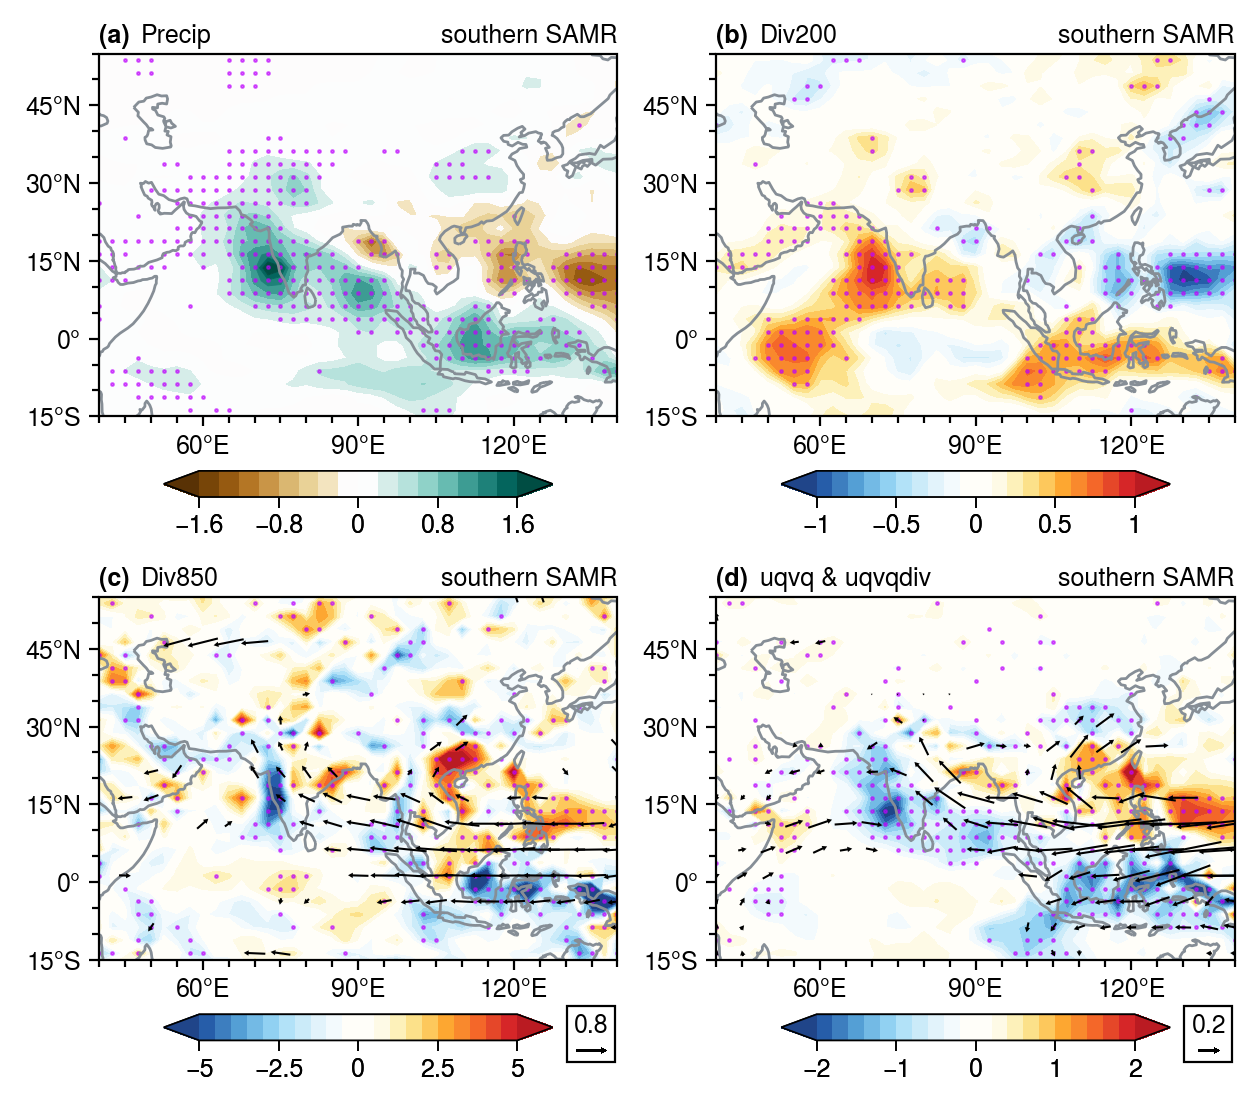

In [45]:
pplt.rc.reset()
pplt.rc.grid = False
startlevel=[-15, -8, -6]
spacinglevel=[1.5, 0.8, 0.6]
scalelevel=[0.30, 0.17, 0.14]
divstartlevel = [-1, -5]
divspacinglevel=[1e-1, 5e-1]
uqvqdivstartlevel = -2
uqvqdivspacinglevel = 0.2
uqvqdivscale=0.05

cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

# fig2 = pplt.figure(span=False, share=False, refwidth=6.0, wspace=6.0, hspace=5.5, outerpad=2.0)
fig_pre_200_850div_water_south = pplt.figure(span=False, share=False, figwidth="16cm", hspace=4.0, outerpad=1.0)
axs = fig_pre_200_850div_water_south.subplots(ncols=2, nrows=2, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(-15, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=font_size, lonminorspace=5, coastlinewidth=1.0, majorticklabelpad=3.0, majorticklen=3.5, minorticklen=2.5)
# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ===================================================
con = axs[0].contourf(
    sIndR_GPCP_pre_slope,
    cmap=prep_colormap,
    # cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-1.6,1.7,0.2),
    zorder=0.8,
    extend="both"
    )
sepl.plt_sig(
    sIndR_GPCP_pre_slope, axs[0], n, np.where(sIndR_GPCP_pre_pvalue[::n, ::n] < 0.10), "bright purple", 5.0,
)

axs[0].format(
    ltitle="Precip", rtitle="southern SAMR",
)
axs[0].colorbar(con, loc="b", width=0.13, length=0.75, label="", ticklabelsize=font_size)
# ===================================================
con = axs[1].contourf(
    sIndR_ERA5_div_slope.sel(level=200.0)*1e6,
    levels=np.arange(divstartlevel[0], -divstartlevel[0]+divspacinglevel[0], divspacinglevel[0]),
    zorder=0.8,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    extend="both"
    )
sepl.plt_sig(
    sIndR_ERA5_div_slope.sel(level=200.0), axs[1], n, np.where(sIndR_ERA5_div_pvalue.sel(level=200.0)[::n, ::n] < 0.10), "bright purple", 5.0,
)

axs[1].format(
    ltitle="Div200", rtitle="southern SAMR",
)
axs[1].colorbar(con, loc="b", width=0.13, length=0.75, label="", ticklabelsize=font_size)
# ===================================================
con = axs[2].contourf(
    sIndR_ERA5_div_slope.sel(level=850.0)*1e7,
    levels=np.arange(divstartlevel[1], -divstartlevel[1]+divspacinglevel[1], divspacinglevel[1]),
    zorder=0.8,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    extend="both"
    )
sepl.plt_sig(
    sIndR_ERA5_div_slope.sel(level=850.0), axs[2], n, np.where(sIndR_ERA5_div_pvalue.sel(level=850.0)[::n, ::n] < 0.10), "bright purple", 5.0,
)

axs[2].format(
    ltitle="Div850", rtitle="southern SAMR",
)
axs[2].colorbar(con, loc="b", width=0.13, length=0.75, label="", ticklabelsize=font_size)

m = axs[2].quiver(
        sIndR_ERA5_uJJA_slope.sel(level=850).where(sIndR_ERA5_windJJA_mask.sel(level=850) > 0.0)[::ski, ::ski],
        sIndR_ERA5_vJJA_slope.sel(level=850).where(sIndR_ERA5_windJJA_mask.sel(level=850) > 0.0)[::ski, ::ski],
        zorder=1.1,
        headwidth=2.6,
        headlength=2.3,
        headaxislength=2.3,
        minlength=0.5,
        width=0.004,
        scale_units="xy",
        scale=scalelevel[2],
        pivot="mid",
        color="black",
    )
scale_ref = 0.8
qk = axs[2].quiverkey(m, 0.95, -0.25, scale_ref, str(scale_ref)+'', labelpos='N', labelsep=0.06, coordinates='axes', fontproperties={"size": font_size})
rect = Rectangle((0.45,0.04), 0.038, 0.05, transform=fig_pre_200_850div_water_south.transFigure, fc="none", ec="k", lw=0.8, zorder=100.1)
fig_pre_200_850div_water_south.add_artist(rect)
# ===================================================
con = axs[3].contourf(
    sIndR_ERA5_uqvqdiv_slope*1e7,
    levels=np.arange(uqvqdivstartlevel, -uqvqdivstartlevel+uqvqdivspacinglevel, uqvqdivspacinglevel),
    zorder=0.8,
    cmap="ColdHot",
    cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
    extend="both"
    )
sepl.plt_sig(
    sIndR_ERA5_uqvqdiv_slope, axs[3], n, np.where(sIndR_ERA5_uqvqdiv_pvalue[::n, ::n] < 0.10), "bright purple", 5.0,
)
m = axs[3].quiver(
      sIndR_ERA5_uq_slope.where(sIndR_ERA5_uqvq_mask > 0.0)[::ski, ::ski],
      sIndR_ERA5_vq_slope.where(sIndR_ERA5_uqvq_mask > 0.0)[::ski, ::ski],
      zorder=1.1,
      headwidth=2.6,
      headlength=2.3,
      headaxislength=2.3,
      minlength=0.5,
      width=0.004,
      scale_units="xy",
      scale=uqvqdivscale,
      pivot="mid",
      color="black",
    )
axs[3].format(
    ltitle="uqvq & uqvqdiv", rtitle="southern SAMR",
)
scale_ref = 0.2
qk = axs[3].quiverkey(m, 0.95, -0.25, scale_ref, str(scale_ref)+'', labelpos='N', labelsep=0.06, coordinates='axes', fontproperties={"size": font_size})

rect = Rectangle((0.94,0.04), 0.038, 0.05, transform=fig_pre_200_850div_water_south.transFigure, fc="none", ec="k", lw=0.8, zorder=100.1)
fig_pre_200_850div_water_south.add_artist(rect)


cb = axs[3].colorbar(con, loc="b", width=0.13, length=0.75, label="", ticklabelsize=font_size)

# cborientation = cb.ax.get_position(original=True)
# cbx, cby, cbw, cbh = cborientation.x0, cborientation.y0, cborientation.width, cborientation.height
# rectx0 = cbx+cbw+0.008
# recty0 = 0.085
# rextx0 = -5
# recty0 = 0.05
# rectw = 0.08
# recth = 0.06
# rect = Rectangle((rectx0, recty0), rectw, recth, transform=fig_pre_200_850div_water_south.transFigure, fc="white", ec="k", lw=0.8, zorder=1.1)
# fig_pre_200_850div_water_south.add_artist(rect)
# qk = plt.quiverkey(
#     m, X=rectx0+0.5*rectw, Y=recty0+recth*0.2, U=0.5, label="1.0", labelpos="N", labelsep=0.06, fontproperties={"size": font_size}, zorder=3.1, coordinates="figure"
# )
# fig_pre_200_850div_water_south.add_artist(qk)



# ===================================================
axs.format(linewidth=0.8, titlepad=4.0)

# cborientation = cb.ax.get_position(original=True)
# cbx, cby, cbw, cbh = cborientation.x0, cborientation.y0, cborientation.width, cborientation.height
# rectx0 = cbx+cbw+0.008
# recty0 = 0.085
# rectw = 0.055
# recth = 0.09
# rect = Rectangle((rectx0, recty0), rectw, recth, transform=fig_pre_200_850div_water_south.transFigure, fc="white", ec="k", lw=0.8, zorder=1.1)
# fig_pre_200_850div_water_south.add_artist(rect)
# qk = plt.quiverkey(
#     m, X=rectx0+0.5*rectw, Y=recty0+recth*0.2, U=1.0, label="1.0", labelpos="N", labelsep=0.06, fontproperties={"size": font_size}, zorder=3.1, coordinates="figure"
# )
# fig_pre_200_850div_water_south.add_artist(qk)

fig_pre_200_850div_water_south.format(abc="(a)", abcloc="l", rc_kw={"grid": False, "reso":"lo", "figure.facecolor":"white", "font.large":font_size})
pplt.rc.reset()

## 前冬前春同期海温回归到南部

/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = li

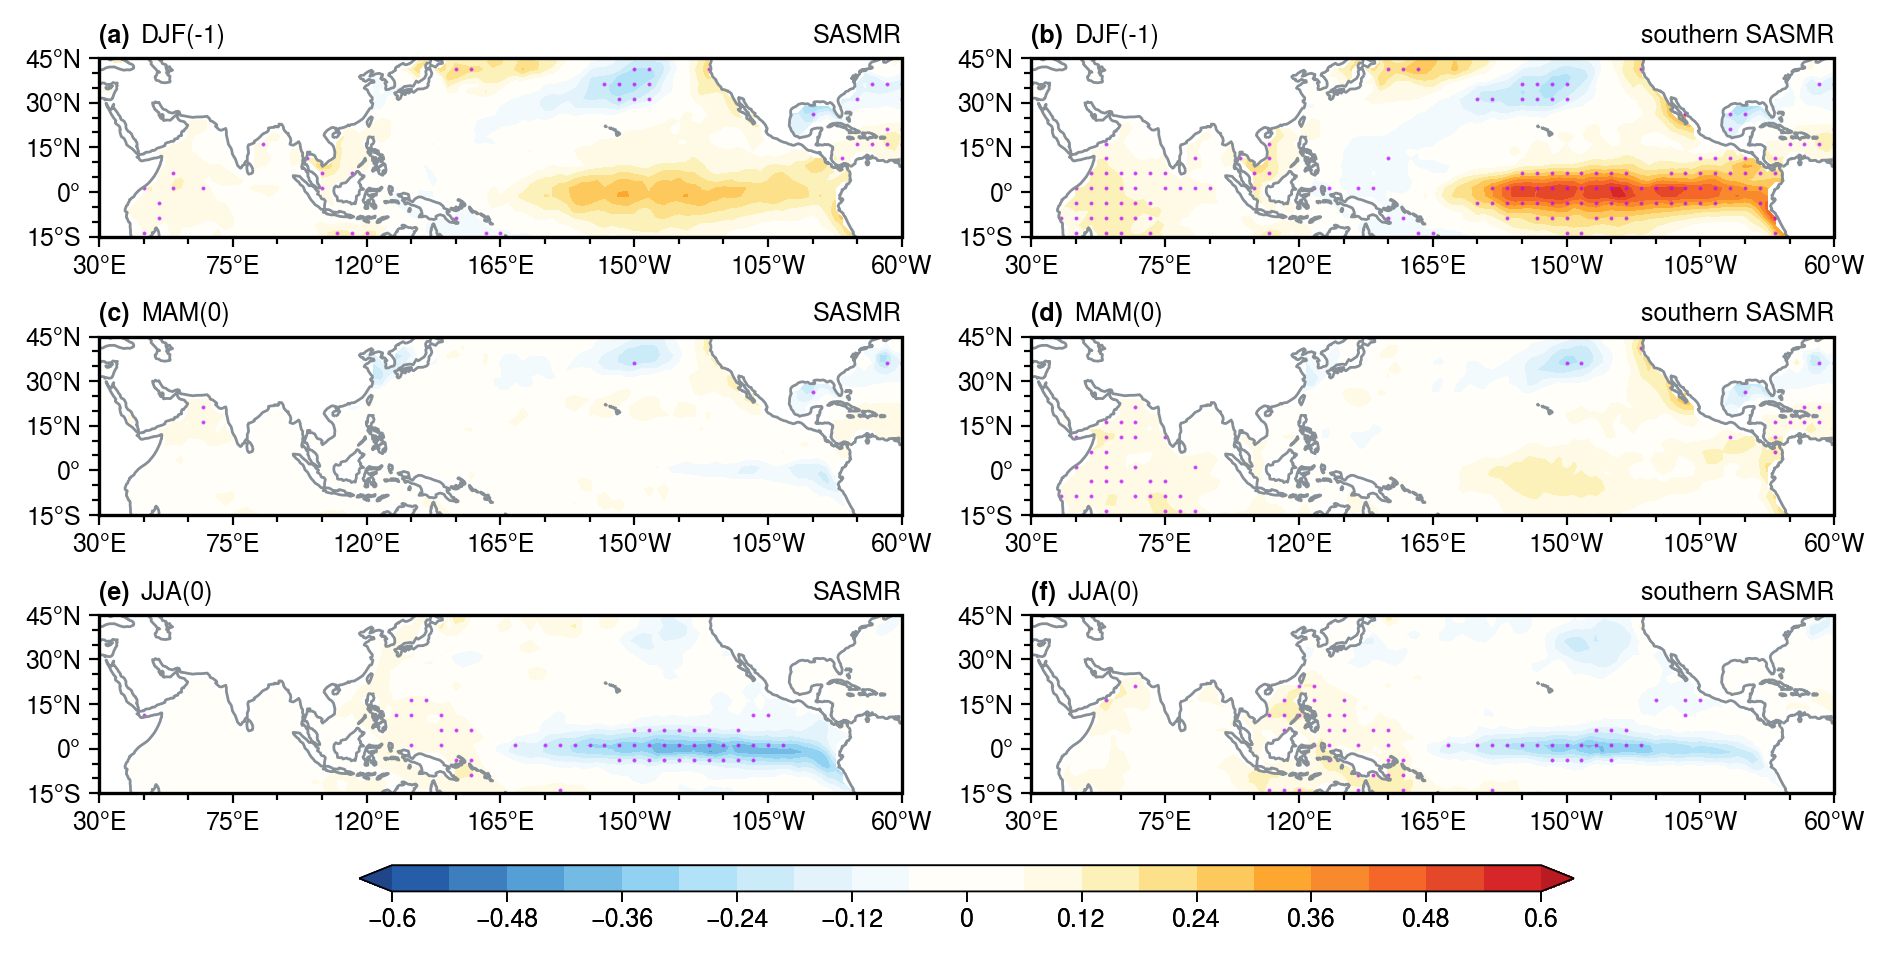

In [54]:
pplt.rc.reset()
pplt.rc.grid = False
startlevel=-6e-1
spacinglevel=0.06
cl = 180  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig_SST_sIndR = pplt.figure(span=False, share=False, figwidth="24cm", hspace=4.0, outerpad=1.0)
nrows = 3
ncols = 2
plot_array = np.reshape(range(1, nrows*ncols+1), (nrows, ncols))
axs = fig_SST_sIndR.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([30, 75, 120, 165, 210, 255, 300])  # 设置纬度刻度
yticks = np.arange(-15, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [xticks[0], xticks[-1], -15, yticks[-1]]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=font_size, latminorspace=5, coastlinewidth=1.0, majorticklabelpad=3.0, majorticklen=3.5, minorticklen=2.5, lonminorspace=15)
# ===================================================
ski = 2
n = 2
w, h = 0.12, 0.14
# ======================================
for (i, season), plot_slope, plot_pvalue in zip(enumerate(["DJF(-1)", "MAM(0)", "JJA(0)", "SON(0)", "DJ(0)F(1)"]), 
      [IndR_ERA5_sstDJF_slope, 
        IndR_ERA5_sstMAM_slope, 
        IndR_ERA5_sstJJA_slope], 
      [IndR_ERA5_sstDJF_pvalue, 
        IndR_ERA5_sstMAM_pvalue, 
        IndR_ERA5_sstJJA_pvalue]):
  con = axs[i, 0].contourf(
      plot_slope,
      cmap="ColdHot",
      cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
      levels=np.arange(startlevel, -startlevel+spacinglevel, spacinglevel),
      zorder=0.8,
      extend="both"
  )
  sepl.plt_sig(
      plot_slope, axs[i, 0], n, np.where(plot_pvalue[::n, ::n] <= 0.05), "bright purple", 3.0,
  )

  axs[i, 0].format(
      ltitle="{}".format(season), rtitle="SASMR",
  )
# ======================================
for (i, season), plot_slope, plot_pvalue in zip(enumerate(["DJF(-1)", "MAM(0)", "JJA(0)", "SON(0)", "DJ(0)F(1)"]), 
      [sIndR_ERA5_sstDJF_slope, 
      sIndR_ERA5_sstMAM_slope, 
      sIndR_ERA5_sstJJA_slope], 
      [sIndR_ERA5_sstDJF_pvalue, 
      sIndR_ERA5_sstMAM_pvalue, 
      sIndR_ERA5_sstJJA_pvalue]):
  con = axs[i, 1].contourf(
      plot_slope,
      cmap="ColdHot",
      cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
      levels=np.arange(startlevel, -startlevel+spacinglevel, spacinglevel),
      zorder=0.8,
      extend="both"
  )
  sepl.plt_sig(
      plot_slope, axs[i, 1], n, np.where(plot_pvalue[::n, ::n] <= 0.05), "bright purple", 3.0,
  )

  axs[i, 1].format(
      ltitle="{}".format(season), rtitle="southern SASMR",
  )
# ======================================
cb = fig_SST_sIndR.colorbar(con, loc="b", width=0.13, length=0.7, label="", ticklabelsize=font_size, pad=1.2)
cb.set_ticks(np.arange(startlevel,-startlevel+0.01,0.12))
# # ======================================
# startlevel=-1.0
# spacinglevel=0.1
# # ======================================
# con = axs[3].contourf(
#     IndR_diff_sst_slope_gens,
#     cmap="ColdHot",
#     cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
#     levels=np.arange(startlevel, -startlevel+spacinglevel, spacinglevel),
#     zorder=0.8,
#     extend="both"
# )
# sepl.plt_sig(
#     IndR_diff_sst_slope_gens, axs[3], n, np.where(IndR_diff_sst_slope_gens_mask[::n, ::n] > 0.00), "bright purple", 3.0,
# )
# axs[3].format(
#     ltitle="diff", rtitle="gMME",
# )
# cb = axs[3].colorbar(con, loc="b", width=0.13, length=0.7, label="", ticklabelsize=8.0)
# cb.set_ticks(np.arange(-1.0,1.1,0.4))
# ======================================
axs.format(linewidth=1.2, titlepad=5.5)
fig_SST_sIndR.format(abc="(a)", abcloc="l", rc_kw={"figure.facecolor":"white", "font.large":font_size, "legend.fontsize":font_size, "grid":False, "reso":"lo"})
pplt.rc.reset()